In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import numpy as np
import pickle as pkl
from os.path import join
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from collections import defaultdict
from core.utils.GAN_utils import BigGAN_wrapper, Caffenet, loadBigGAN
from core.utils.layer_hook_utils import featureFetcher_module, featureFetcher
from core.utils.plot_utils import to_imgrid, make_grid, show_imgrid
from core.utils.plot_utils import saveallforms
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pytorch_pretrained_biggan import BigGAN, one_hot_from_names, truncated_noise_sample, one_hot_from_int
from torchvision.transforms import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\ponce\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Alignment of BigGAN latent codes with Caffenet activations

In [3]:
# Initialize Caffenet
caffenet_model = Caffenet()
caffenet_model.to(device)
caffenet_model.eval()

# Initialize BigGAN
BG = loadBigGAN()
BG.to(device).eval()
G = BigGAN_wrapper(BG)

In [4]:
# Sampling 5000 random latent codes
num_samples = 5000
latent_dim = 128  # BigGAN latent dimension
truncation = 0.7
latent_codes = truncated_noise_sample(truncation=truncation, batch_size=num_samples)
noise_latent_codes = torch.tensor(latent_codes, dtype=torch.float32).to(device)
class_ids = torch.randint(0, 1000, (num_samples,))
class_ids_one_hot = F.one_hot(class_ids, num_classes=1000)
# to one hot
class_latent_codes = G.BigGAN.embeddings(class_ids_one_hot.float().to(device))
print(class_latent_codes.shape) 
print(noise_latent_codes.shape)
latent_codes_all = torch.cat([noise_latent_codes, class_latent_codes], dim=1)

torch.Size([5000, 128])
torch.Size([5000, 128])


### Testing this BigGAN

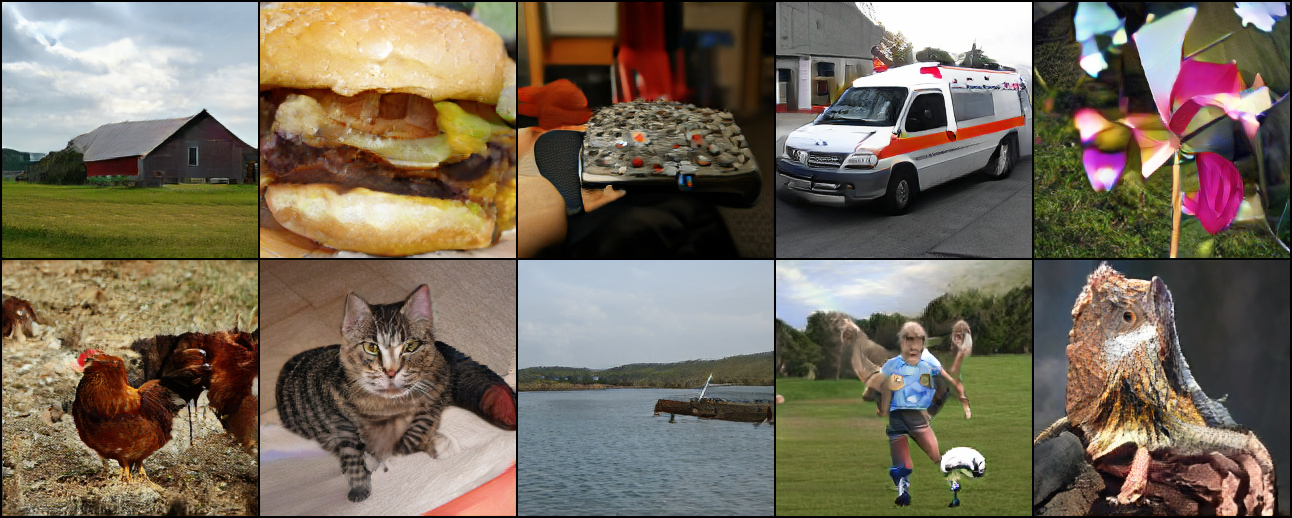

Image 0: Class ID 425 - barn
Image 1: Class ID 933 - cheeseburger
Image 2: Class ID 761 - remote_control
Image 3: Class ID 407 - ambulance
Image 4: Class ID 723 - pinwheel
Image 5: Class ID 8 - hen
Image 6: Class ID 281 - tabby
Image 7: Class ID 913 - wreck
Image 8: Class ID 805 - soccer_ball
Image 9: Class ID 43 - frilled_lizard


In [6]:
import json
import urllib.request

# Download ImageNet class index
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
response = urllib.request.urlopen(url)
imagenet_classes = json.loads(response.read())

latent_codes_all = torch.cat([noise_latent_codes, class_latent_codes], dim=1)
with torch.no_grad():
    imgs = G.visualize(latent_codes_all[:10])
    
display(to_imgrid(imgs, nrow=5))

for i in range(10):
    class_id = class_ids[i].item()
    class_name = imagenet_classes[str(class_id)][1]  # Get human readable class name
    print(f"Image {i}: Class ID {class_id} - {class_name}")


### Streaming and recording activations


In [5]:
def get_center_activation(tensor, max_channel=None):
    if max_channel is None:
        max_channel = tensor.shape[1]
    if len(tensor.shape) == 2:
        return tensor[:, :max_channel]
    elif len(tensor.shape) == 4:
        B, C, H, W = tensor.shape
        return tensor[:, :max_channel, H//2, W//2]
    else:
        raise ValueError(f"Expected tensor with 2 or 4 dimensions, got {len(tensor.shape)}")

In [6]:
fetcher = featureFetcher_module()
for name, layer in caffenet_model.net.named_children():
    if name == "flatten":
        continue
    fetcher.record_module(layer, name, ingraph=False, store_device="cpu")

In [7]:
# Define transformation to match Caffenet input requirements
transform = transforms.Compose([
    transforms.Resize(224),
    # Note no need to normalize, as the model perform normalization inside
])

activation_storage = defaultdict(list)

# Create DataLoader for batch processing
batch_size = 25
for csr in trange(0, len(latent_codes_all), batch_size):
    latent_codes_all_batch = latent_codes_all[csr:csr+batch_size]
    with torch.no_grad():
        imgs = G.visualize(latent_codes_all_batch)
    imgs = transform(imgs)
    with torch.no_grad():
        _ = caffenet_model(imgs, preproc=True)
    
    for name, activation in fetcher.activations.items():
        activation_storage[name].append(get_center_activation(activation))

# Concatenate activations
for layer in activation_storage:
    activation_storage[layer] = torch.cat(activation_storage[layer], dim=0)

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


In [8]:
for layer in activation_storage:
    print(layer, activation_storage[layer].shape)

savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\BigGAN_Caffenet"
os.makedirs(savedir, exist_ok=True)
# Save the raw data used for analysis
pkl.dump({"latent_codes": latent_codes_all.cpu(), 
          "class_ids": class_ids.cpu(),
          "activation_storage": activation_storage}, open(join(savedir, "BigGAN_Caffenet_data.pkl"), "wb"))

conv1 torch.Size([5000, 96])
relu1 torch.Size([5000, 96])
pool1 torch.Size([5000, 96])
norm1 torch.Size([5000, 96])
conv2 torch.Size([5000, 256])
relu2 torch.Size([5000, 256])
pool2 torch.Size([5000, 256])
norm2 torch.Size([5000, 256])
conv3 torch.Size([5000, 384])
relu3 torch.Size([5000, 384])
conv4 torch.Size([5000, 384])
relu4 torch.Size([5000, 384])
conv5 torch.Size([5000, 256])
relu5 torch.Size([5000, 256])
pool5 torch.Size([5000, 256])
fc6 torch.Size([5000, 4096])
relu6 torch.Size([5000, 4096])
fc7 torch.Size([5000, 4096])
relu7 torch.Size([5000, 4096])
fc8 torch.Size([5000, 1000])


#### Reverse Regression: Caffenet activations predicting BigGAN latent codes

In [9]:
X = latent_codes_all.detach().cpu().numpy()
results = []

for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    # target_idx = np.arange(activation.shape[1])
    y = activation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_noise = X_train[:, :128]
    X_train_class = X_train[:, 128:]
    X_test_noise = X_test[:, :128]
    X_test_class = X_test[:, 128:]
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train)
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(X_train, ridge.predict(y_train), multioutput=None)
    r2_scores = r2_score(X_test, ridge.predict(y_test), multioutput=None)
    
    ridge_class = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train_class)
    r2_scores_class = r2_score(X_test_class, ridge_class.predict(y_test))
    r2_train_class = r2_score(X_train_class, ridge_class.predict(y_train))

    ridge_noise = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(y_train, X_train_noise)
    r2_scores_noise = r2_score(X_test_noise, ridge_noise.predict(y_test))
    r2_train_noise = r2_score(X_train_noise, ridge_noise.predict(y_train))
    # Create dictionary entries for all targets at once

    results.append({
        'Layer': layer,
        'num_features': activation.shape[1],
        'reverse_Train_R2': r2_train,
        'reverse_Test_R2': r2_scores,
        'reverse_Train_R2_class': r2_train_class,
        'reverse_Test_R2_class': r2_scores_class,
        'reverse_Train_R2_noise': r2_train_noise,
        'reverse_Test_R2_noise': r2_scores_noise
    })

# Summarize results
reverse_results_df = pd.DataFrame(results)

In [11]:
from os.path import join
from core.utils.plot_utils import saveallforms
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\BigGAN_Caffenet"
os.makedirs(savedir, exist_ok=True)

reverse_results_df.to_csv(join(savedir, "latent_code_linearity_results_reverse_regression.csv"), index=False)

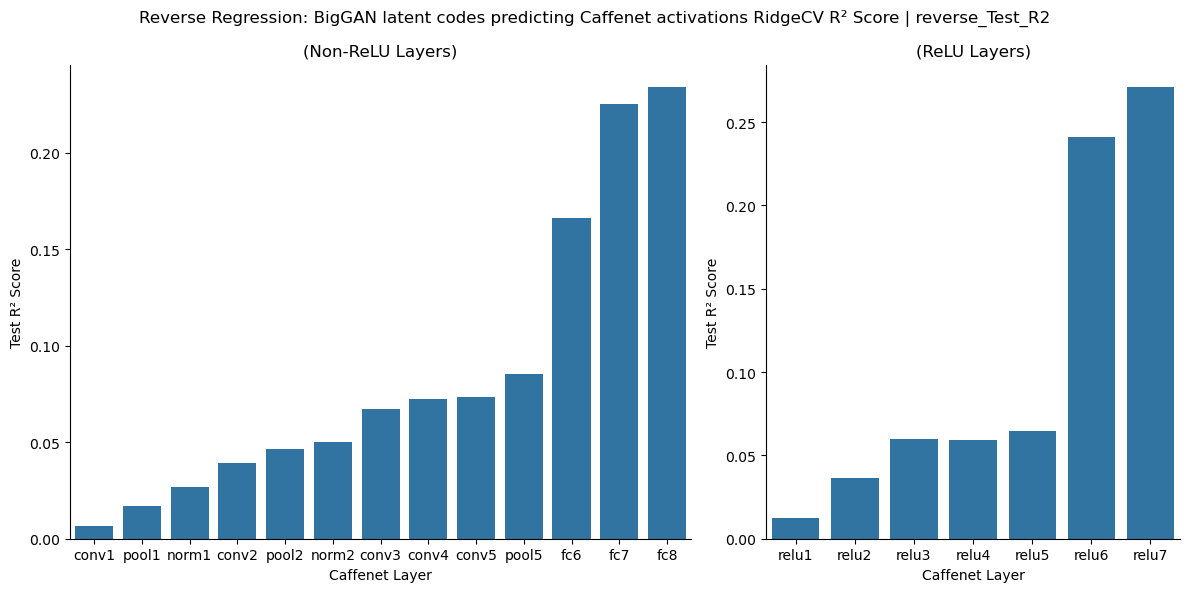

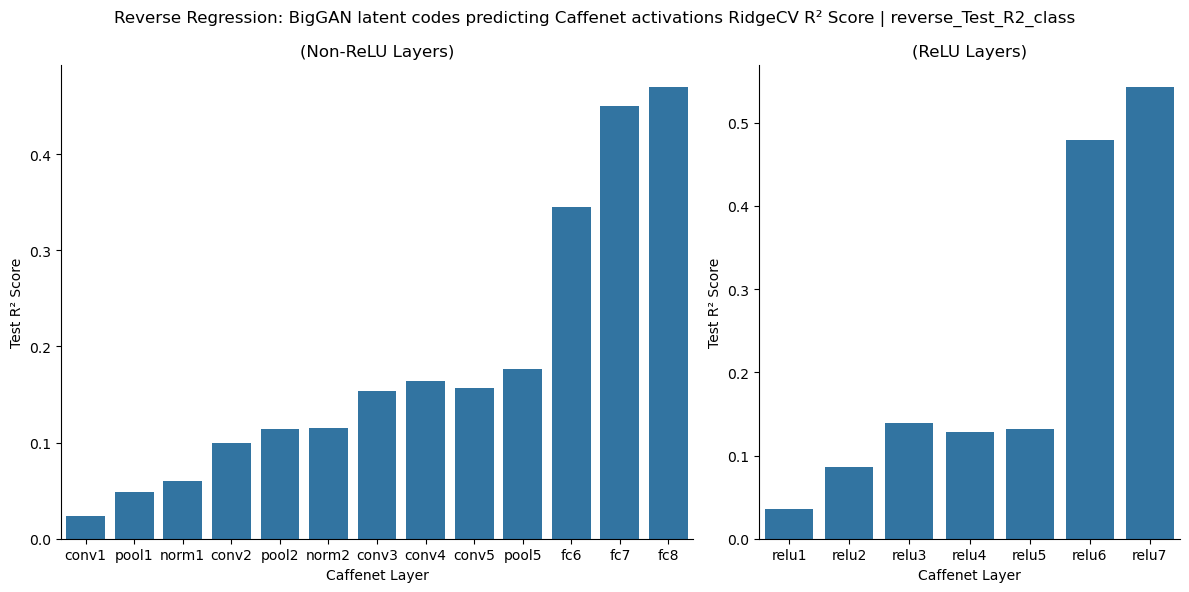

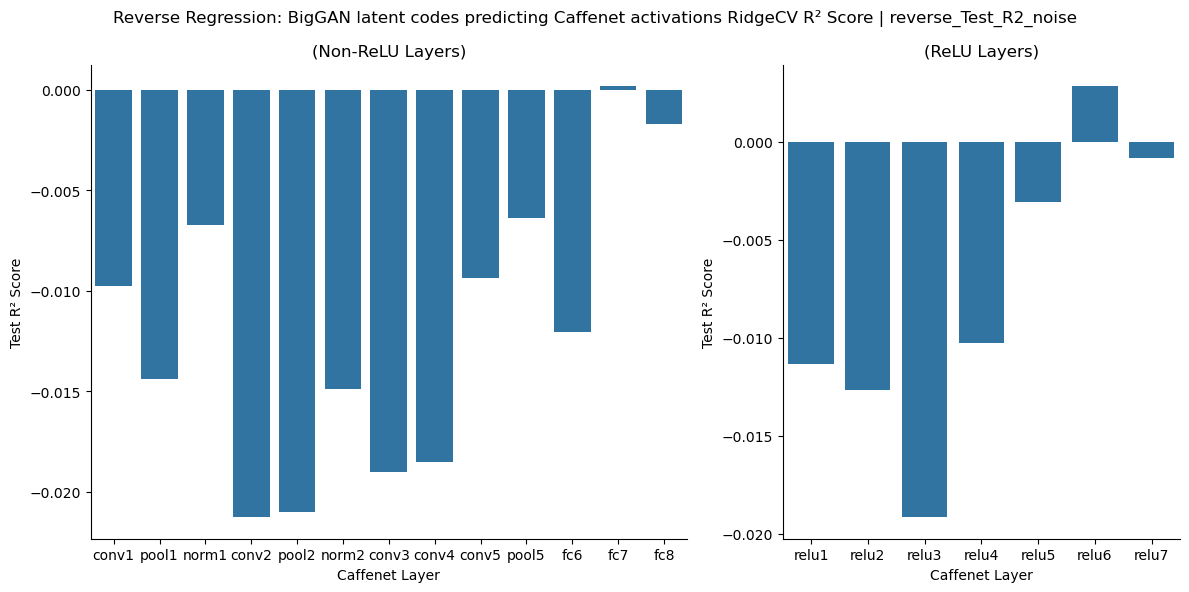

In [12]:
for y_variable in ['reverse_Test_R2', 'reverse_Test_R2_class', 'reverse_Test_R2_noise']:
    figh, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]})
    sns.barplot(x='Layer', y=y_variable, data=reverse_results_df.query('not Layer.str.contains("relu")'), ax=ax1)
    ax1.set_title('(Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    sns.barplot(x='Layer', y=y_variable, data=reverse_results_df.query('Layer.str.contains("relu")'), ax=ax2)
    ax2.set_title('(ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    plt.suptitle(f'Reverse Regression: BigGAN latent codes predicting Caffenet activations RidgeCV R² Score | {y_variable}')
    plt.tight_layout()
    saveallforms(savedir, f"BigGAN_Caffenet_{y_variable}_reverse_regression_barplot")
    plt.show()

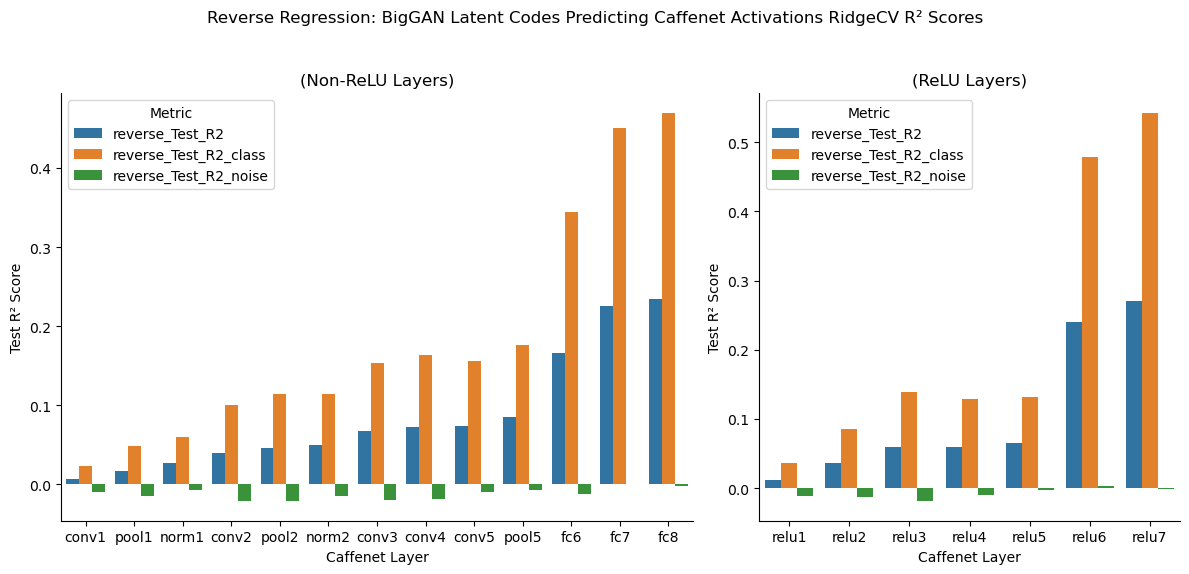

In [14]:
y_variables = ['reverse_Test_R2', 'reverse_Test_R2_class', 'reverse_Test_R2_noise']
reverse_melted_df = reverse_results_df.melt(id_vars='Layer', value_vars=y_variables, var_name='Metric', value_name='Test_R2_Score')

figh, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]})
sns.barplot(x='Layer', y='Test_R2_Score', hue='Metric', data=reverse_melted_df.query('not Layer.str.contains("relu")'), ax=ax1)
ax1.set_title('(Non-ReLU Layers)')
ax1.set_xlabel('Caffenet Layer')
ax1.set_ylabel('Test R² Score')
ax1.legend(title='Metric')

sns.barplot(x='Layer', y='Test_R2_Score', hue='Metric', data=reverse_melted_df.query('Layer.str.contains("relu")'), ax=ax2)
ax2.set_title('(ReLU Layers)')
ax2.set_xlabel('Caffenet Layer')
ax2.set_ylabel('Test R² Score')
ax2.legend(title='Metric')

plt.suptitle('Reverse Regression: BigGAN Latent Codes Predicting Caffenet Activations RidgeCV R² Scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
saveallforms(savedir, "BigGAN_Caffenet_reverse_regression_grouped_barplot")
plt.show()

#### Forward Regression: BigGAN latent codes predicting Caffenet activations

In [15]:
X = latent_codes_all.cpu().numpy()
results = []

for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    target_idx = np.arange(activation.shape[1])
    y = activation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_noise = X_train[:, :128]
    X_train_class = X_train[:, 128:]
    X_test_noise = X_test[:, :128]
    X_test_class = X_test[:, 128:]
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train, y_train)
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(y_train, ridge.predict(X_train), multioutput='raw_values')
    r2_scores = r2_score(y_test, ridge.predict(X_test), multioutput='raw_values')
    
    ridge_class = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train_class, y_train)
    r2_scores_class = r2_score(y_test, ridge_class.predict(X_test_class), multioutput='raw_values')
    r2_train_class = r2_score(y_train, ridge_class.predict(X_train_class), multioutput='raw_values')

    ridge_noise = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train_noise, y_train)
    r2_scores_noise = r2_score(y_test, ridge_noise.predict(X_test_noise), multioutput='raw_values')
    r2_train_noise = r2_score(y_train, ridge_noise.predict(X_train_noise), multioutput='raw_values')
    # Create dictionary entries for all targets at once

    results.extend([{
        'Layer': layer,
        'Target': idx,
        'Train_R2': r2_train[idx],
        'Test_R2': r2_scores[idx],
        'Train_R2_class': r2_train_class[idx],
        'Test_R2_class': r2_scores_class[idx],
        'Train_R2_noise': r2_train_noise[idx],
        'Test_R2_noise': r2_scores_noise[idx]
    } for idx in zip(target_idx)])


# Summarize results
results_df = pd.DataFrame(results)

In [18]:
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\BigGAN_Caffenet"
os.makedirs(savedir, exist_ok=True)
# Save the raw data used for analysis
pkl.dump({"latent_codes": latent_codes_all.cpu(), 
          "class_ids": class_ids.cpu(),
          "activation_storage": activation_storage}, open(join(savedir, "BigGAN_Caffenet_data.pkl"), "wb"))

# Save the full results DataFrame
results_df.to_csv(join(savedir, "latent_code_linearity_results.csv"), index=False)

# Save summary statistics per layer
layer_summary = results_df.groupby('Layer').agg({
    'Test_R2': ['mean', 'std', 'median'],
    'Test_R2_class': ['mean', 'std', 'median'], 
    'Test_R2_noise': ['mean', 'std', 'median']
}).round(4)
layer_summary.to_csv(join(savedir, "layer_summary_stats.csv"))


#### Visualize the forward regression results

In [6]:
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\BigGAN_Caffenet"
results_df = pd.read_csv(join(savedir, "latent_code_linearity_results.csv"))

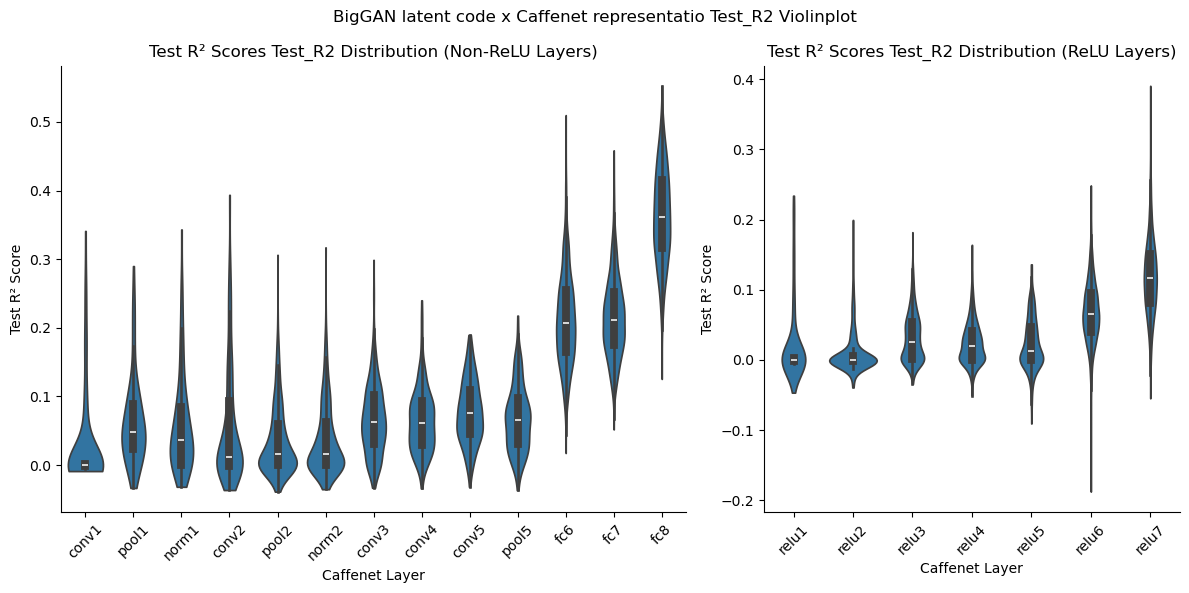

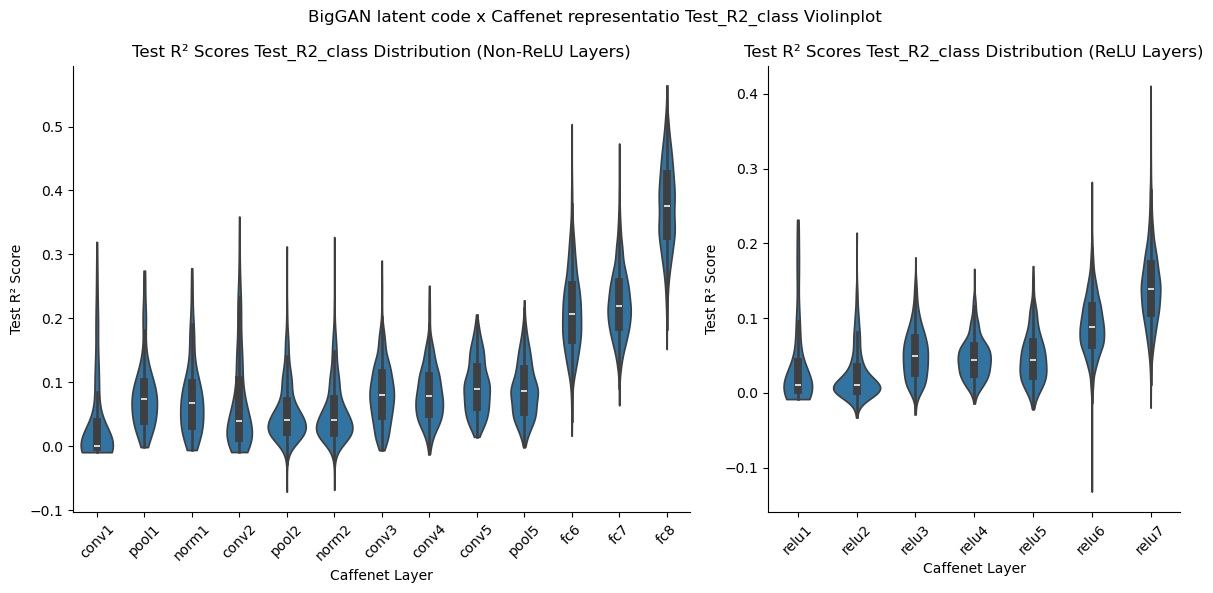

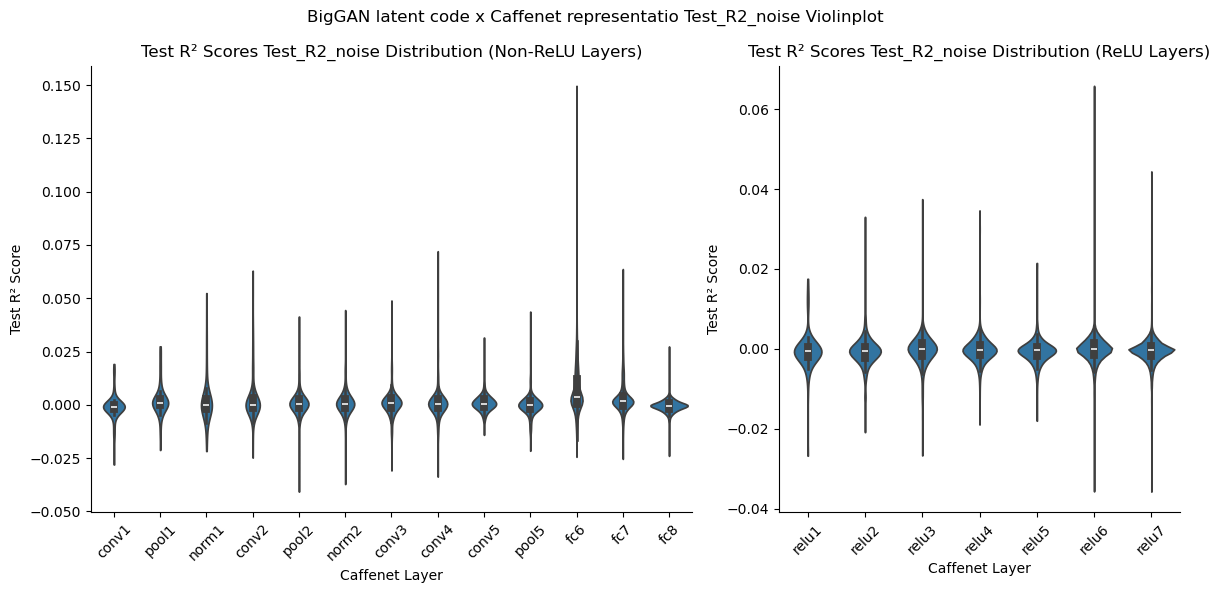

In [21]:
# Plot the results
for y_variable in ["Test_R2", 'Test_R2_class', 'Test_R2_noise']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]})
    # Plot for layers without relu

    sns.violinplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, cut=0)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.violinplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, cut=0)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    plt.suptitle(f"BigGAN latent code x Caffenet representatio {y_variable} Violinplot")
    plt.tight_layout()
    saveallforms(savedir, f"BigGAN_Caffenet_{y_variable}_violinplot")
    plt.show()


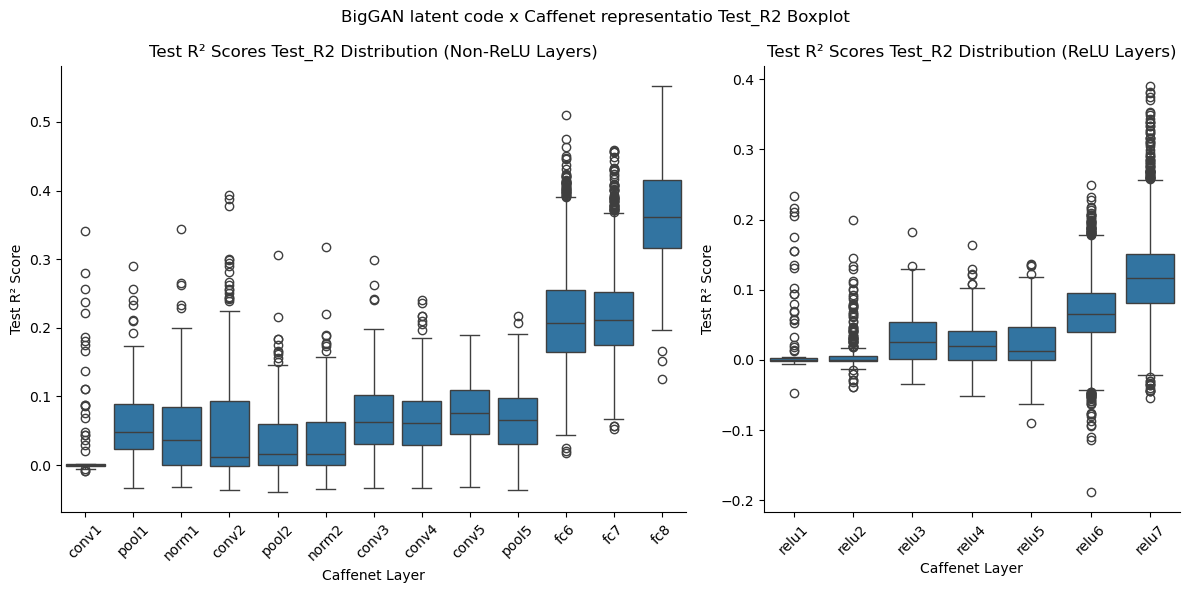

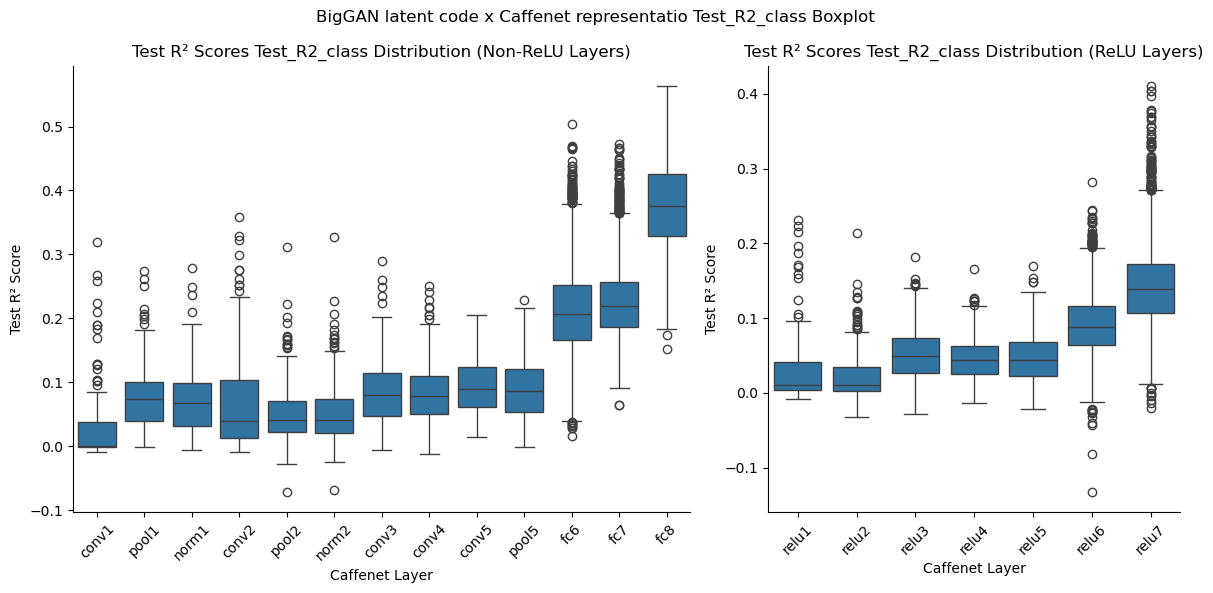

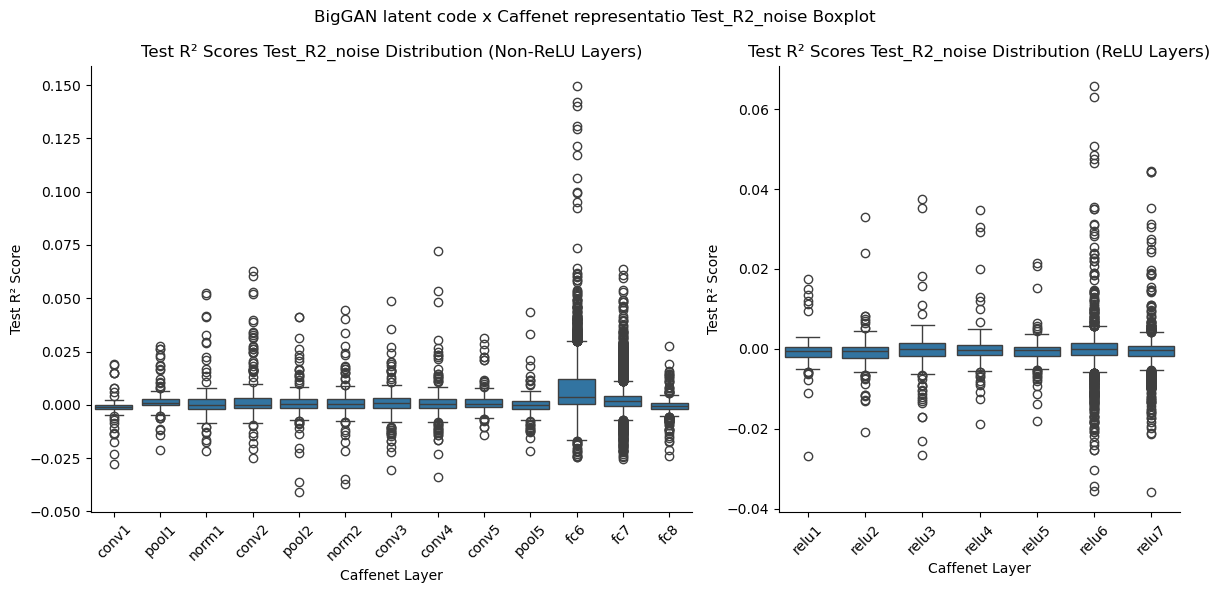

In [20]:
# Plot the results
for y_variable in ["Test_R2", 'Test_R2_class', 'Test_R2_noise']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]})
    # Plot for layers without relu
    sns.boxplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, )
    ax1.tick_params(axis='x', rotation=45)

    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.boxplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, )
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    plt.suptitle(f"BigGAN latent code x Caffenet representatio {y_variable} Boxplot")
    plt.tight_layout()
    saveallforms(savedir, f"BigGAN_Caffenet_{y_variable}_boxplot")
    plt.show()

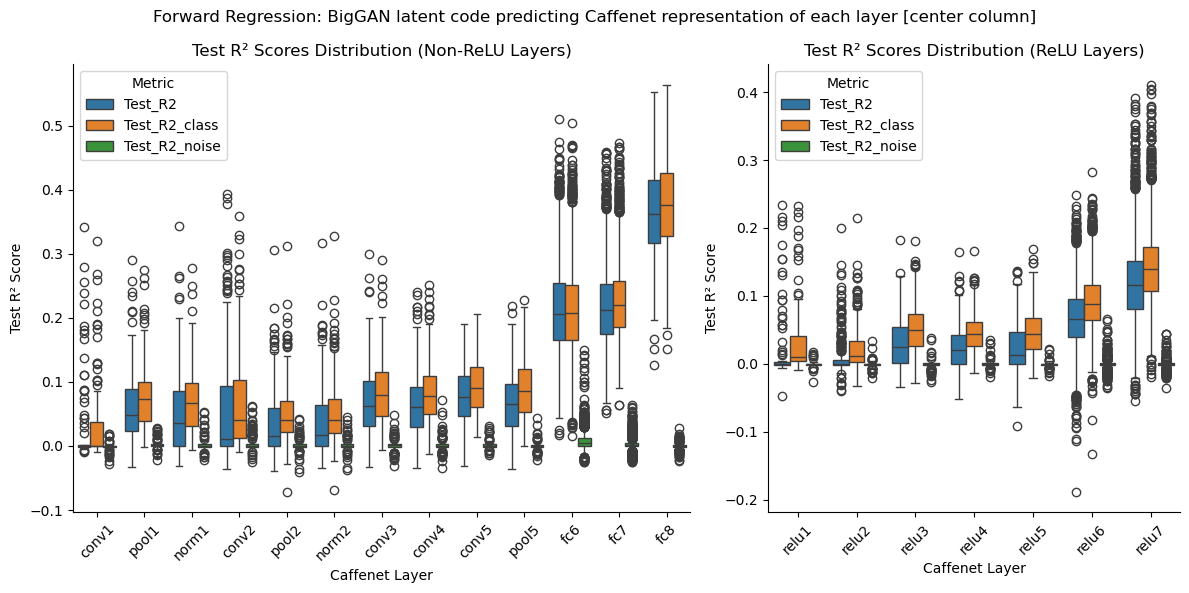

In [24]:
# for layer_type, title_suffix in [("not Layer.str.contains('relu')", 'Non-ReLU Layers'), ("Layer.str.contains('relu')", 'ReLU Layers')]:
melted_df = results_df.melt(id_vars=['Layer'], value_vars=["Test_R2", 'Test_R2_class', 'Test_R2_noise'], var_name='Metric', value_name='Score')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]})
sns.boxplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("not Layer.str.contains('relu')"), ax=ax1)
ax1.tick_params(axis='x', rotation=45)
ax1.set_title(f'Test R² Scores Distribution (Non-ReLU Layers)')
ax1.set_xlabel('Caffenet Layer')
ax1.set_ylabel('Test R² Score')

sns.boxplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("Layer.str.contains('relu')"), ax=ax2)
ax2.tick_params(axis='x', rotation=45)
ax2.set_title(f'Test R² Scores Distribution (ReLU Layers)')
ax2.set_xlabel('Caffenet Layer')
ax2.set_ylabel('Test R² Score')
plt.suptitle("Forward Regression: BigGAN latent code predicting Caffenet representation of each layer [center column]")
plt.tight_layout()
saveallforms(savedir, "BigGAN_Caffenet_combined_boxplot")
plt.show()

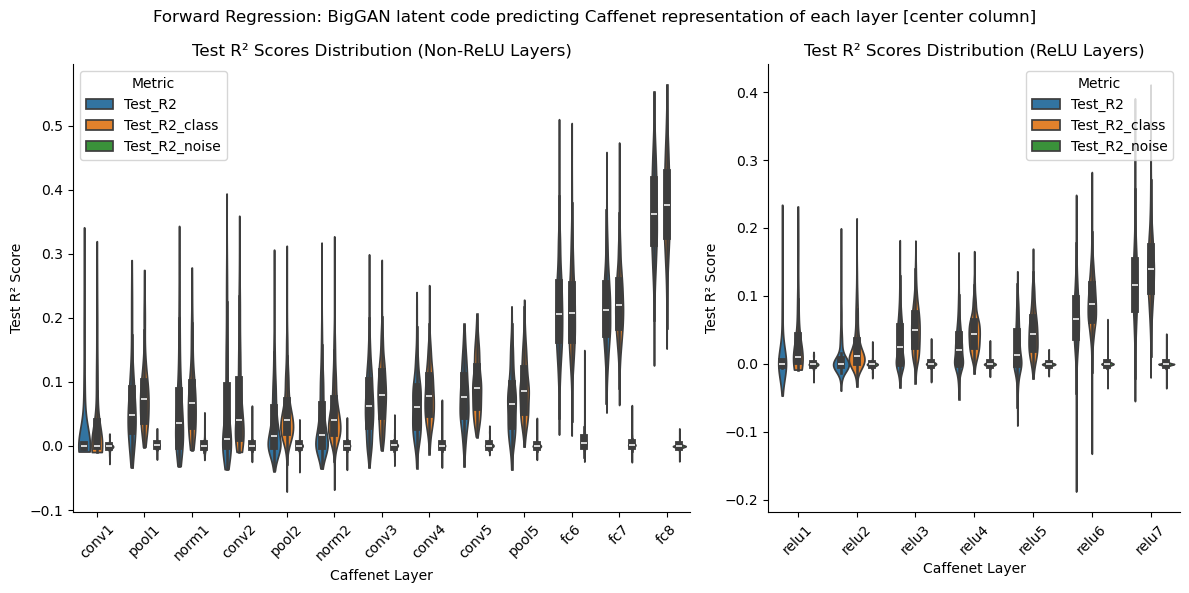

In [27]:
# for layer_type, title_suffix in [("not Layer.str.contains('relu')", 'Non-ReLU Layers'), ("Layer.str.contains('relu')", 'ReLU Layers')]:
melted_df = results_df.melt(id_vars=['Layer'], value_vars=["Test_R2", 'Test_R2_class', 'Test_R2_noise'], var_name='Metric', value_name='Score')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]})
sns.violinplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("not Layer.str.contains('relu')"), ax=ax1, cut=0, width=0.8)
ax1.tick_params(axis='x', rotation=45)
ax1.set_title(f'Test R² Scores Distribution (Non-ReLU Layers)')
ax1.set_xlabel('Caffenet Layer')
ax1.set_ylabel('Test R² Score')

sns.violinplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("Layer.str.contains('relu')"), ax=ax2, cut=0, width=0.8)
ax2.tick_params(axis='x', rotation=45)
ax2.set_title(f'Test R² Scores Distribution (ReLU Layers)')
ax2.set_xlabel('Caffenet Layer')
ax2.set_ylabel('Test R² Score')

plt.suptitle("Forward Regression: BigGAN latent code predicting Caffenet representation of each layer [center column]")
plt.tight_layout()
saveallforms(savedir, "BigGAN_Caffenet_combined_violinplot")
plt.show()

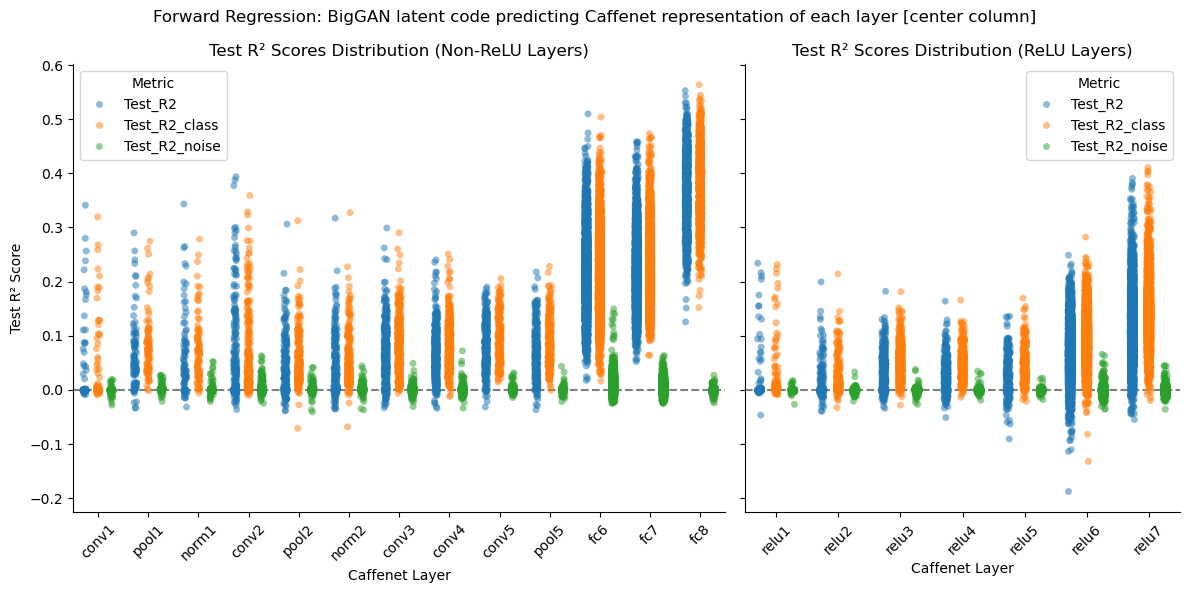

In [11]:
# for layer_type, title_suffix in [("not Layer.str.contains('relu')", 'Non-ReLU Layers'), ("Layer.str.contains('relu')", 'ReLU Layers')]:
melted_df = results_df.melt(id_vars=['Layer'], value_vars=["Test_R2", 'Test_R2_class', 'Test_R2_noise'], var_name='Metric', value_name='Score')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 1]}, sharey=True)
sns.stripplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("not Layer.str.contains('relu')"), ax=ax1, dodge=True, alpha=0.5)
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.tick_params(axis='x', rotation=45)
ax1.set_title(f'Test R² Scores Distribution (Non-ReLU Layers)')
ax1.set_xlabel('Caffenet Layer')
ax1.set_ylabel('Test R² Score')
sns.stripplot(x='Layer', y='Score', hue='Metric', data=melted_df.query("Layer.str.contains('relu')"), ax=ax2, dodge=True, alpha=0.5)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.tick_params(axis='x', rotation=45)
ax2.set_title(f'Test R² Scores Distribution (ReLU Layers)')
ax2.set_xlabel('Caffenet Layer')
ax2.set_ylabel('Test R² Score')
plt.suptitle("Forward Regression: BigGAN latent code predicting Caffenet representation of each layer [center column]")
plt.tight_layout()
saveallforms(savedir, "BigGAN_Caffenet_combined_stripplot")
plt.show()


In [19]:
results_df.iloc[0].Target

'(0,)'

In [16]:
results_df.head()

Layer Target  Train_R2   Test_R2  Train_R2_class  Test_R2_class  \
0  conv1   (0,)  0.000088 -0.000252    8.582048e-07      -0.000255   
1  conv1   (1,)  0.000978 -0.000917    9.965588e-04      -0.000734   
2  conv1   (2,)  0.009265 -0.000817    1.050699e-02       0.003331   
3  conv1   (3,)  0.010319 -0.001313    9.196306e-07      -0.000053   
4  conv1   (4,)  0.001016 -0.000217    9.407119e-07      -0.000108   

   Train_R2_noise  Test_R2_noise  Layer_index  
0        0.000087      -0.000251            0  
1        0.000967      -0.000919            0  
2        0.009063      -0.000956            0  
3        0.010230      -0.001333            0  
4        0.001007      -0.000215            0

In [23]:
from scipy.stats import spearmanr
# Label layers with their index
layer_to_index = {name: idx for idx, (name, _) in enumerate(caffenet_model.net.named_children())}
index_to_layer = {idx: name for name, idx in layer_to_index.items()}

results_df['Layer_index'] = results_df['Layer'].map(layer_to_index)
results_df['unit_index'] = results_df['Target'].map(lambda x: int(eval(x)[0]))
# Separate non-ReLU and ReLU layers
non_relu_df = results_df.query('not Layer.str.contains("relu")')
relu_df = results_df.query('Layer.str.contains("relu")')
non_relu_df_match_num = results_df.query('not Layer.str.contains("relu") and unit_index < 96')
relu_df_match_num = results_df.query('Layer.str.contains("relu") and unit_index < 96')

# Define R² metrics to analyze
r2_metrics = ['Test_R2', 'Test_R2_class', 'Test_R2_noise']
for df_split, label in zip([non_relu_df_match_num, relu_df_match_num, non_relu_df, relu_df], 
                           ['Non-ReLU Layers (unit number matched)', 'ReLU Layers (unit number matched)', 'Non-ReLU Layers', 'ReLU Layers']):
    print(f"Spearman correlations for {label}:")
    for metric in r2_metrics:
        corr, p_val = spearmanr(df_split['Layer_index'], df_split[metric])
        print(f"{metric}: Spearman correlation = {corr:.3f}, p-value = {p_val:.2e}")


Spearman correlations for Non-ReLU Layers (unit number matched):
Test_R2: Spearman correlation = 0.670, p-value = 3.19e-163
Test_R2_class: Spearman correlation = 0.693, p-value = 4.32e-179
Test_R2_noise: Spearman correlation = 0.051, p-value = 7.33e-02
Spearman correlations for ReLU Layers (unit number matched):
Test_R2: Spearman correlation = 0.573, p-value = 6.26e-60
Test_R2_class: Spearman correlation = 0.657, p-value = 3.19e-84
Test_R2_noise: Spearman correlation = 0.019, p-value = 6.19e-01
Spearman correlations for Non-ReLU Layers:
Test_R2: Spearman correlation = 0.626, p-value = 0.00e+00
Test_R2_class: Spearman correlation = 0.659, p-value = 0.00e+00
Test_R2_noise: Spearman correlation = -0.054, p-value = 7.56e-09
Spearman correlations for ReLU Layers:
Test_R2: Spearman correlation = 0.593, p-value = 0.00e+00
Test_R2_class: Spearman correlation = 0.625, p-value = 0.00e+00
Test_R2_noise: Spearman correlation = -0.043, p-value = 2.96e-05


### DeePSim CaffeNet    

In [59]:
from tqdm.auto import trange, tqdm
from collections import defaultdict
from core.utils.GAN_utils import upconvGAN

In [63]:
def get_center_activation(tensor, max_channel=None):
    if max_channel is None:
        max_channel = tensor.shape[1]
    if len(tensor.shape) == 2:
        return tensor[:, :max_channel]
    elif len(tensor.shape) == 4:
        B, C, H, W = tensor.shape
        return tensor[:, :max_channel, H//2, W//2]
    else:
        raise ValueError(f"Expected tensor with 2 or 4 dimensions, got {len(tensor.shape)}")

In [60]:
# Initialize Caffenet
caffenet_model = Caffenet()
caffenet_model.to(device)
caffenet_model.eval()

# Initialize BigGAN
DP_G = upconvGAN("fc6").to(device).eval()


In [79]:
# Sampling 5000 random latent codes
num_samples = 5000
latent_codes_all = 4 * torch.randn(num_samples, 4096).to(device)

In [80]:
fetcher = featureFetcher_module()

for name, layer in caffenet_model.net.named_children():
    if name == "flatten":
        continue
    fetcher.record_module(layer, name, ingraph=False, store_device="cpu")


In [81]:
# Define transformation to match Caffenet input requirements
transform = transforms.Compose([
    transforms.Resize(224),
    # Note no need to normalize, as the model perform normalization inside
])

activation_storage = defaultdict(list)

# Create DataLoader for batch processing
batch_size = 50
for csr in trange(0, len(latent_codes_all), batch_size):
    latent_codes_all_batch = latent_codes_all[csr:csr+batch_size]
    imgs = DP_G.visualize(latent_codes_all_batch)
    imgs = transform(imgs)
    with torch.no_grad():
        _ = caffenet_model(imgs, preproc=True)
    
    for name, activation in fetcher.activations.items():
        activation_storage[name].append(get_center_activation(activation))

# Concatenate activations
for layer in activation_storage:
    activation_storage[layer] = torch.cat(activation_storage[layer], dim=0)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


In [82]:
for layer in activation_storage:
    print(layer, activation_storage[layer].shape)

conv1 torch.Size([5000, 96])
relu1 torch.Size([5000, 96])
pool1 torch.Size([5000, 96])
norm1 torch.Size([5000, 96])
conv2 torch.Size([5000, 256])
relu2 torch.Size([5000, 256])
pool2 torch.Size([5000, 256])
norm2 torch.Size([5000, 256])
conv3 torch.Size([5000, 384])
relu3 torch.Size([5000, 384])
conv4 torch.Size([5000, 384])
relu4 torch.Size([5000, 384])
conv5 torch.Size([5000, 256])
relu5 torch.Size([5000, 256])
pool5 torch.Size([5000, 256])
fc6 torch.Size([5000, 4096])
relu6 torch.Size([5000, 4096])
fc7 torch.Size([5000, 4096])
relu7 torch.Size([5000, 4096])
fc8 torch.Size([5000, 1000])


In [ ]:
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\DeePSim_FC6_Caffenet"
os.makedirs(savedir, exist_ok=True)
# Save the raw data used for analysis
pkl.dump({"latent_codes": latent_codes_all.cpu(), 
          "activation_storage": activation_storage}, open(join(savedir, "DeePSim_FC6_Caffenet_data.pkl"), "wb"))

#### Loading Hessian eigenframe

In [24]:
# Load the Hessian eigenspace 
import numpy as np
import sys

# Define paths to Hessian files based on the operating system
if sys.platform == "linux":
    # Define Linux paths
    Hdir_fc6 = "/n/scratch3/users/b/biw905/Hessian_summary/fc6GAN/Evolution_Avg_Hess.npz"
else:
    # Define Windows paths
    Hdir_fc6 = r"E:\OneDrive - Washington University in St. Louis\Hessian_summary\fc6GAN\Evolution_Avg_Hess.npz"

# Load the Hessian for fc6
H_fc6 = np.load(Hdir_fc6)

if H_fc6 is not None:
    eigvals_fc6 = H_fc6['eigv_avg']
    eigvecs_fc6 = H_fc6['eigvect_avg']
    print(f"Loaded fc6 Hessian with {len(eigvals_fc6)} eigenvalues.")
    assert eigvals_fc6[-1] > eigvals_fc6[0] # check that the eigenvalues are sorted in ascending order
else:
    print("Failed to load fc6 Hessian.")



Loaded fc6 Hessian with 4096 eigenvalues.


In [25]:
top_Hess512_proj = eigvecs_fc6[:, -512:]
top_Hess256_proj = eigvecs_fc6[:, -256:]
top_Hess128_proj = eigvecs_fc6[:, -128:]
null_Hess512_proj = eigvecs_fc6[:, :512]
null_Hess256_proj = eigvecs_fc6[:, :256]
null_Hess128_proj = eigvecs_fc6[:, :128]

In [26]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


In [27]:
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\DeePSim_FC6_Caffenet"
# load latent codes
with open(join(savedir, "DeePSim_FC6_Caffenet_data.pkl"), "rb") as f:
    data = pkl.load(f)
latent_codes_all = data["latent_codes"]
activation_storage = data["activation_storage"]

#### Reverse Regression



In [ ]:
X = latent_codes_all.detach().cpu().numpy()
results = []
for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    y = activation.detach().cpu().numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 12, 20), alpha_per_target=True).fit(y_train, X_train, )
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(X_train, ridge.predict(y_train), multioutput=None)
    r2_scores = r2_score(X_test, ridge.predict(y_test), multioutput=None)
    r2_collection = {"reverse_Train_R2": r2_train, "reverse_Test_R2": r2_scores}
    # Project the activations onto the top 512 eigenspace
    for proj_mat, proj_label in zip([top_Hess512_proj, top_Hess256_proj, top_Hess128_proj, null_Hess512_proj, null_Hess256_proj, null_Hess128_proj], 
                                    ['top_Hess512', 'top_Hess256', 'top_Hess128', 'null_Hess512', 'null_Hess256', 'null_Hess128']):
        proj_train = X_train @ proj_mat
        proj_test = X_test @ proj_mat
        # Ridge Regression
        ridge_proj = RidgeCV(alphas=np.logspace(-6, 12, 20), alpha_per_target=True).fit(y_train, proj_train, )
        r2_scores_proj = r2_score(proj_test, ridge_proj.predict(y_test), multioutput=None)
        r2_train_proj = r2_score(proj_train, ridge_proj.predict(y_train), multioutput=None)
        r2_collection[f"reverse_Train_R2_{proj_label}"] = r2_train_proj
        r2_collection[f"reverse_Test_R2_{proj_label}"] = r2_scores_proj


    base_data = [{
        'Layer': layer,
        'num_features': activation.shape[1],
        **r2_collection
    }]
    df_part = pd.DataFrame(base_data)
    display(df_part)
    results.append(df_part)

# Summarize results
reverse_results_df = pd.concat(results)

In [35]:
from os.path import join
from core.utils.plot_utils import saveallforms

reverse_results_df.to_csv(join(savedir, "latent_code_linearity_results_reverse_regression.csv"), index=False)

In [37]:
reverse_results_df

Layer  num_features  reverse_Train_R2  reverse_Test_R2  reverse_Train_R2_top_Hess512  reverse_Test_R2_top_Hess512  reverse_Train_R2_top_Hess256  reverse_Test_R2_top_Hess256  reverse_Train_R2_top_Hess128  reverse_Test_R2_top_Hess128  reverse_Train_R2_null_Hess512  reverse_Test_R2_null_Hess512  reverse_Train_R2_null_Hess256  reverse_Test_R2_null_Hess256  reverse_Train_R2_null_Hess128  reverse_Test_R2_null_Hess128
0  conv1            96          0.001780        -0.001501                      0.014991                     0.004080                      0.025395                     0.009173                      0.034476                     0.016087                       0.000669                     -0.001570                       0.000634                     -0.001547                       0.000628                     -0.001572
0  relu1            96          0.001987        -0.001474                      0.014430                     0.003583                      0.023148                     0.008407                      0.030422                     0.013767                       0.000839                     -0.001544                       0.000880                     -0.001474                       0.000902                     -0.001526
0  pool1            96          0.002649        -0.001406                      0.019358                     0.006161                      0.030125                     0.012439                      0.038545                     0.019390                       0.001000                     -0.001629                       0.001060                     -0.001594                       0.000937                     -0.001488
0  norm1            96          0.003439        -0.001209                      0.020554                     0.007168                      0.031587                     0.013612                      0.039746                     0.020876                       0.001247                     -0.001565                       0.001486                     -0.001562                       0.001476                     -0.001502
0  conv2           256          0.006575        -0.000787                      0.064130                     0.027107                      0.098871                     0.048296                      0.122807                     0.067680                       0.001368                     -0.001534                       0.001413                     -0.001533                       0.001390                     -0.001537
0  relu2           256          0.005318        -0.001050                      0.036857                     0.012006                      0.054303                     0.023054                      0.065723                     0.033090                       0.001862                     -0.001532                       0.002034                     -0.001543                       0.002067                     -0.001603
0  pool2           256          0.008517        -0.000893                      0.055148                     0.020463                      0.084587                     0.036607                      0.105036                     0.051616                       0.001776                     -0.001552                       0.001927                     -0.001545                       0.001626                     -0.001462
0  norm2           256          0.008494        -0.000670                      0.055592                     0.021584                      0.082593                     0.038737                      0.098811                     0.053638                       0.002064                     -0.001564                       0.002055                     -0.001580                       0.001867                     -0.001613
0  conv3           384          0.009580        -0.000568                      0.095729                     0.043046                      0.142284                     0.076027                      0.177757                     0.103883       

#### Forward Regression

In [103]:
X = latent_codes_all.cpu().numpy()
results = []
for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    target_idx = np.arange(activation.shape[1])
    y = activation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 12, 20), alpha_per_target=True).fit(X_train, y_train)
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(y_train, ridge.predict(X_train), multioutput='raw_values')
    r2_scores = r2_score(y_test, ridge.predict(X_test), multioutput='raw_values')
    r2_collection = {"Train_R2": r2_train, "Test_R2": r2_scores}
    # Project the activations onto the top 512 eigenspace
    for proj_mat, proj_label in zip([top_Hess512_proj, top_Hess256_proj, top_Hess128_proj, null_Hess512_proj, null_Hess256_proj, null_Hess128_proj], 
                                    ['top_Hess512', 'top_Hess256', 'top_Hess128', 'null_Hess512', 'null_Hess256', 'null_Hess128']):
        proj_train = X_train @ proj_mat
        proj_test = X_test @ proj_mat
        # Ridge Regression
        ridge_proj = RidgeCV(alphas=np.logspace(-6, 12, 20), alpha_per_target=True).fit(proj_train, y_train)
        r2_scores_proj = r2_score(y_test, ridge_proj.predict(proj_test), multioutput='raw_values')
        r2_train_proj = r2_score(y_train, ridge_proj.predict(proj_train), multioutput='raw_values')
        r2_collection[f"Train_R2_{proj_label}"] = r2_train_proj
        r2_collection[f"Test_R2_{proj_label}"] = r2_scores_proj

    base_data = {
        'Layer': layer,
        'Target': target_idx,
        'Train_R2': r2_collection['Train_R2'],
        'Test_R2': r2_collection['Test_R2'],
    }
    projections = ['top_Hess512', 'top_Hess256', 'top_Hess128', 'null_Hess512', 'null_Hess256', 'null_Hess128']
    for proj in projections:
        base_data[f'Train_R2_{proj}'] = r2_collection[f'Train_R2_{proj}']
        base_data[f'Test_R2_{proj}'] = r2_collection[f'Test_R2_{proj}']
    df_part = pd.DataFrame(base_data)
    display(df_part.describe().T)
    results.append(df_part)

# Summarize results
results_df = pd.concat(results)

count       mean        std           min           25%           50%        75%        max
Target                  96.0  47.500000  27.856777  0.000000e+00  2.375000e+01  4.750000e+01  71.250000  95.000000
Train_R2                96.0   0.303750   0.175012  8.066469e-04  6.448458e-02  3.565952e-01   0.376870   0.828808
Test_R2                 96.0   0.037659   0.040761 -2.419640e-02  4.774311e-03  2.272942e-02   0.064652   0.158118
Train_R2_top_Hess512    96.0   0.263730   0.124391  8.208903e-03  2.085284e-01  2.610452e-01   0.326483   0.562111
Test_R2_top_Hess512     96.0   0.141237   0.116786 -3.425176e-03  4.237005e-02  1.061054e-01   0.208815   0.465785
Train_R2_top_Hess256    96.0   0.209458   0.105955  2.952355e-02  1.417014e-01  1.768558e-01   0.251230   0.506577
Test_R2_top_Hess256     96.0   0.136026   0.105835 -1.712424e-03  5.534912e-02  1.010431e-01   0.192055   0.477469
Train_R2_top_Hess128    96.0   0.149367   0.094576  1.714074e-02  8.624975e-02  1.151886e-01   0.197903   0.464551
Test_R2_top_Hess128     96.0   0.112586   0.097942 -2.375785e-03  4.126833e-02  8.370909e-02   0.162106   0.463484
Train_R2_null_Hess512   96.0   0.004364   0.011011 -4.877809e-09  1.313822e-08  1.949699e-08   0.007738   0.054602
Test_R2_null_Hess512    96.0  -0.002267   0.002769 -1.550096e-02 -3.115109e-03 -1.389237e-03  -0.000590   0.001246
Train_R2_null_Hess256   96.0   0.003433   0.007729 -1.204475e-08  7.109007e-09  1.553937e-08   0.003960   0.028655
Test_R2_null_Hess256    96.0  -0.002145   0.002190 -1.034317e-02 -3.454189e-03 -1.475508e-03  -0.000521   0.001046
Train_R2_null_Hess128   96.0   0.003118   0.005315 -1.593826e-08  3.913780e-09  2.259248e-04   0.002064   0.015291
Test_R2_null_Hess128    96.0  -0.002187   0.002474 -1.289063e-02 -3.472537e-03 -1.508409e-03  -0.000487   0.004646

count       mean        std           min           25%           50%        75%        max
Target                  96.0  47.500000  27.856777  0.000000e+00  2.375000e+01  4.750000e+01  71.250000  95.000000
Train_R2                96.0   0.252483   0.158680  5.973566e-02  6.338489e-02  3.490860e-01   0.361976   0.817997
Test_R2                 96.0   0.025121   0.031431 -1.956478e-02  3.912493e-03  1.323160e-02   0.036853   0.162792
Train_R2_top_Hess512    96.0   0.224649   0.108983  6.190119e-02  1.686375e-01  2.332828e-01   0.277149   0.560180
Test_R2_top_Hess512     96.0   0.104140   0.089724 -9.539665e-04  3.182797e-02  7.915093e-02   0.145389   0.434300
Train_R2_top_Hess256    96.0   0.178371   0.084705  3.529262e-02  1.242885e-01  1.630854e-01   0.203655   0.511759
Test_R2_top_Hess256     96.0   0.105056   0.083779 -5.018412e-03  4.795182e-02  8.620295e-02   0.142006   0.441836
Train_R2_top_Hess128    96.0   0.124790   0.076914  1.868943e-02  7.542537e-02  1.107846e-01   0.142808   0.469077
Test_R2_top_Hess128     96.0   0.086258   0.077951  3.721213e-03  3.533831e-02  6.675860e-02   0.107264   0.439563
Train_R2_null_Hess512   96.0   0.002865   0.003798 -1.734654e-08  1.388773e-08  4.081551e-08   0.007840   0.008475
Test_R2_null_Hess512    96.0  -0.001430   0.001572 -7.485162e-03 -2.297811e-03 -9.516834e-04  -0.000261   0.001041
Train_R2_null_Hess256   96.0   0.001992   0.003428 -2.472077e-08  1.056173e-08  2.483753e-04   0.003981   0.029187
Test_R2_null_Hess256    96.0  -0.001530   0.001590 -7.701627e-03 -2.288761e-03 -1.103177e-03  -0.000333   0.000713
Train_R2_null_Hess128   96.0   0.003067   0.005272 -2.833388e-08  7.881642e-09  2.506235e-05   0.002049   0.015496
Test_R2_null_Hess128    96.0  -0.001899   0.002080 -1.403322e-02 -2.859006e-03 -1.370257e-03  -0.000373   0.000087

count       mean        std           min           25%           50%        75%        max
Target                  96.0  47.500000  27.856777  0.000000e+00  2.375000e+01  4.750000e+01  71.250000  95.000000
Train_R2                96.0   0.393865   0.090976  3.444515e-01  3.638783e-01  3.723441e-01   0.384980   0.825980
Test_R2                 96.0   0.060625   0.031603  4.380360e-03  3.719895e-02  5.476131e-02   0.076831   0.179955
Train_R2_top_Hess512    96.0   0.341747   0.078600  2.504960e-01  2.912881e-01  3.207220e-01   0.369227   0.585511
Test_R2_top_Hess512     96.0   0.204270   0.084713  9.359705e-02  1.510960e-01  1.821097e-01   0.245303   0.463452
Train_R2_top_Hess256    96.0   0.269670   0.079551  1.532856e-01  2.113043e-01  2.451547e-01   0.319582   0.516407
Test_R2_top_Hess256     96.0   0.188936   0.078699  6.718045e-02  1.337618e-01  1.728796e-01   0.226082   0.453417
Train_R2_top_Hess128    96.0   0.192119   0.077998  6.596982e-02  1.308823e-01  1.864475e-01   0.224321   0.460432
Test_R2_top_Hess128     96.0   0.146671   0.081146  1.885535e-02  8.980376e-02  1.254415e-01   0.189439   0.439703
Train_R2_null_Hess512   96.0   0.003933   0.009866 -1.789740e-08  1.426231e-08  3.904146e-08   0.007736   0.056229
Test_R2_null_Hess512    96.0  -0.001425   0.001731 -7.329009e-03 -2.114077e-03 -7.128761e-04  -0.000225   0.001764
Train_R2_null_Hess256   96.0   0.004658   0.008638 -2.521237e-08  9.050419e-09  4.525443e-04   0.004116   0.033529
Test_R2_null_Hess256    96.0  -0.001754   0.002039 -8.052981e-03 -2.491232e-03 -9.184627e-04  -0.000305   0.000566
Train_R2_null_Hess128   96.0   0.003942   0.005982 -2.865825e-08  4.227213e-09  1.949832e-03   0.002147   0.017663
Test_R2_null_Hess128    96.0  -0.001807   0.002262 -8.993461e-03 -3.352923e-03 -9.688873e-04  -0.000285   0.002825

count       mean        std           min           25%           50%        75%        max
Target                  96.0  47.500000  27.856777  0.000000e+00  2.375000e+01  4.750000e+01  71.250000  95.000000
Train_R2                96.0   0.382532   0.087724  6.381802e-02  3.585024e-01  3.686225e-01   0.381852   0.828588
Test_R2                 96.0   0.054087   0.031134 -3.584466e-04  3.117707e-02  4.921552e-02   0.069948   0.177696
Train_R2_top_Hess512    96.0   0.323268   0.082382  2.269767e-01  2.631870e-01  3.067322e-01   0.347743   0.604302
Test_R2_top_Hess512     96.0   0.185972   0.089726  1.755173e-02  1.232287e-01  1.758143e-01   0.223990   0.484607
Train_R2_top_Hess256    96.0   0.251757   0.082493  1.451092e-01  1.894556e-01  2.348015e-01   0.301547   0.544782
Test_R2_top_Hess256     96.0   0.174159   0.086021  3.906504e-02  1.146616e-01  1.553083e-01   0.204819   0.478469
Train_R2_top_Hess128    96.0   0.183739   0.076830  7.395618e-02  1.269147e-01  1.775818e-01   0.226346   0.472178
Test_R2_top_Hess128     96.0   0.144172   0.084479  2.355104e-02  8.017727e-02  1.237938e-01   0.197733   0.458106
Train_R2_null_Hess512   96.0   0.004988   0.011334 -2.023985e-08  1.487297e-08  2.630200e-08   0.007796   0.057689
Test_R2_null_Hess512    96.0  -0.001198   0.001553 -5.293960e-03 -2.451736e-03 -5.729384e-04  -0.000111   0.001720
Train_R2_null_Hess256   96.0   0.004294   0.008414 -3.035971e-08  7.910551e-09  4.495829e-04   0.004059   0.033124
Test_R2_null_Hess256    96.0  -0.001318   0.001781 -9.587153e-03 -2.453810e-03 -5.894694e-04  -0.000129   0.002722
Train_R2_null_Hess128   96.0   0.003924   0.005971 -3.502991e-08  3.944846e-09  1.075085e-03   0.002130   0.016308
Test_R2_null_Hess128    96.0  -0.001416   0.002040 -1.023407e-02 -2.417262e-03 -8.694304e-04  -0.000137   0.004471

count        mean        std           min           25%           50%         75%         max
Target                 256.0  127.500000  74.045031  0.000000e+00  6.375000e+01  1.275000e+02  191.250000  255.000000
Train_R2               256.0    0.446012   0.151462  3.438352e-01  3.764246e-01  3.894675e-01    0.410731    0.861421
Test_R2                256.0    0.086941   0.051299  4.467541e-03  5.316881e-02  7.547147e-02    0.105378    0.311051
Train_R2_top_Hess512   256.0    0.405111   0.104556  2.212110e-01  3.303002e-01  3.779421e-01    0.483344    0.727553
Test_R2_top_Hess512    256.0    0.270443   0.112179  3.079750e-02  1.917736e-01  2.555403e-01    0.329751    0.621164
Train_R2_top_Hess256   256.0    0.329547   0.101248  1.255861e-01  2.509706e-01  3.164814e-01    0.396152    0.692963
Test_R2_top_Hess256    256.0    0.244878   0.107029  2.748024e-02  1.643801e-01  2.262317e-01    0.308308    0.620281
Train_R2_top_Hess128   256.0    0.233496   0.095301  6.735572e-02  1.734415e-01  2.176957e-01    0.285671    0.656466
Test_R2_top_Hess128    256.0    0.188884   0.102731  1.435162e-02  1.163074e-01  1.722171e-01    0.246065    0.603299
Train_R2_null_Hess512  256.0    0.003958   0.008091 -1.087053e-08  1.537696e-08  2.440168e-08    0.007876    0.055705
Test_R2_null_Hess512   256.0   -0.001486   0.002459 -1.971640e-02 -1.699896e-03 -8.001503e-04   -0.000134    0.001717
Train_R2_null_Hess256  256.0    0.003667   0.007373 -1.908713e-08  7.782994e-09  4.490315e-04    0.004013    0.030755
Test_R2_null_Hess256   256.0   -0.001628   0.002417 -1.624070e-02 -2.019087e-03 -8.772467e-04   -0.000142    0.002266
Train_R2_null_Hess128  256.0    0.002928   0.005129 -2.296146e-08  3.937233e-09  2.250126e-04    0.002051    0.016416
Test_R2_null_Hess128   256.0   -0.001687   0.002272 -1.579355e-02 -2.251527e-03 -9.166755e-04   -0.000158    0.002125

count        mean        std           min           25%           50%         75%    max
Target                 256.0  127.500000  74.045031  0.000000e+00  6.375000e+01  1.275000e+02  191.250000  255.0
Train_R2               256.0    0.204004   0.168850  5.728831e-08  6.134600e-02  6.397057e-02    0.354824    1.0
Test_R2                256.0    0.021219   0.089880 -3.536244e-02  5.922684e-04  4.647799e-03    0.022346    1.0
Train_R2_top_Hess512   256.0    0.177454   0.129414 -6.032340e-08  7.119243e-02  2.055954e-01    0.244938    1.0
Test_R2_top_Hess512    256.0    0.069530   0.106532 -4.145448e-02  1.659279e-02  3.328079e-02    0.094965    1.0
Train_R2_top_Hess256   256.0    0.140996   0.110435 -6.637833e-08  1.030189e-01  1.337188e-01    0.171012    1.0
Test_R2_top_Hess256    256.0    0.070890   0.104892 -1.062258e-02  1.221323e-02  4.595690e-02    0.090313    1.0
Train_R2_top_Hess128   256.0    0.099331   0.100838 -1.581262e-10  5.889890e-02  8.184520e-02    0.117967    1.0
Test_R2_top_Hess128    256.0    0.057606   0.099830 -3.282287e-02  9.494120e-03  3.517860e-02    0.075570    1.0
Train_R2_null_Hess512  256.0    0.010931   0.088138 -5.553741e-08  1.205155e-08  4.174303e-08    0.007802    1.0
Test_R2_null_Hess512   256.0    0.006495   0.088356 -1.335310e-02 -1.518355e-03 -6.247699e-04   -0.000112    1.0
Train_R2_null_Hess256  256.0    0.011007   0.088226 -6.476849e-08  2.748358e-09  3.262774e-08    0.003965    1.0
Test_R2_null_Hess256   256.0    0.006274   0.088390 -1.765353e-02 -1.676383e-03 -6.241960e-04   -0.000135    1.0
Train_R2_null_Hess128  256.0    0.010314   0.088125 -6.875595e-08  4.621878e-09  4.411111e-08    0.002042    1.0
Test_R2_null_Hess128   256.0    0.006199   0.088394 -1.602473e-02 -1.973230e-03 -6.382948e-04   -0.000135    1.0

count        mean        std           min           25%           50%         75%    max
Target                 256.0  127.500000  74.045031  0.000000e+00  6.375000e+01  1.275000e+02  191.250000  255.0
Train_R2               256.0    0.338436   0.131148  9.572082e-08  3.553311e-01  3.686124e-01    0.382715    1.0
Test_R2                256.0    0.047709   0.067911 -3.369170e-02  2.043809e-02  4.247666e-02    0.064273    1.0
Train_R2_top_Hess512   256.0    0.294832   0.119407  5.611711e-08  2.499990e-01  3.006887e-01    0.350981    1.0
Test_R2_top_Hess512    256.0    0.159493   0.107247 -6.974623e-02  9.876009e-02  1.559397e-01    0.208409    1.0
Train_R2_top_Hess256   256.0    0.230799   0.107034  4.902265e-08  1.768436e-01  2.215027e-01    0.288605    1.0
Test_R2_top_Hess256    256.0    0.149797   0.102362 -2.711411e-02  9.632809e-02  1.400250e-01    0.189266    1.0
Train_R2_top_Hess128   256.0    0.164884   0.096635  1.219340e-07  1.046380e-01  1.502659e-01    0.209527    1.0
Test_R2_top_Hess128    256.0    0.115376   0.096186 -1.690031e-02  5.895609e-02  9.894950e-02    0.153714    1.0
Train_R2_null_Hess512  256.0    0.007811   0.062859 -2.819288e-08  1.358744e-08  5.370693e-08    0.007766    1.0
Test_R2_null_Hess512   256.0    0.002454   0.062633 -1.512542e-02 -1.827209e-03 -5.746802e-04   -0.000169    1.0
Train_R2_null_Hess256  256.0    0.007557   0.062700 -3.510071e-08  9.223152e-09  4.485031e-04    0.004029    1.0
Test_R2_null_Hess256   256.0    0.002312   0.062656 -1.947850e-02 -2.013654e-03 -6.539281e-04   -0.000180    1.0
Train_R2_null_Hess128  256.0    0.007193   0.062530 -3.889528e-08  1.002432e-08  1.930858e-03    0.002072    1.0
Test_R2_null_Hess128   256.0    0.002274   0.062640 -1.066322e-02 -2.466164e-03 -7.959955e-04   -0.000185    1.0

count        mean        std           min           25%           50%         75%    max
Target                 256.0  127.500000  74.045031  0.000000e+00  6.375000e+01  1.275000e+02  191.250000  255.0
Train_R2               256.0    0.339484   0.131578  6.698008e-08  3.562660e-01  3.702855e-01    0.384804    1.0
Test_R2                256.0    0.049455   0.068437 -3.174859e-02  2.194851e-02  4.308801e-02    0.065880    1.0
Train_R2_top_Hess512   256.0    0.298267   0.120632 -3.455337e-08  2.542315e-01  3.055509e-01    0.355370    1.0
Test_R2_top_Hess512    256.0    0.164198   0.109358 -6.218598e-02  9.838632e-02  1.580028e-01    0.215519    1.0
Train_R2_top_Hess256   256.0    0.234793   0.108522 -1.335663e-08  1.791676e-01  2.269127e-01    0.294100    1.0
Test_R2_top_Hess256    256.0    0.153959   0.104321 -1.780319e-02  9.794975e-02  1.447777e-01    0.195831    1.0
Train_R2_top_Hess128   256.0    0.167601   0.097925  9.824425e-08  1.074443e-01  1.633091e-01    0.210989    1.0
Test_R2_top_Hess128    256.0    0.118373   0.098021 -1.539395e-02  6.134702e-02  1.016576e-01    0.157265    1.0
Train_R2_null_Hess512  256.0    0.007647   0.062791 -4.530157e-08  1.482615e-08  5.883066e-08    0.007803    1.0
Test_R2_null_Hess512   256.0    0.002430   0.062633 -1.352068e-02 -1.759533e-03 -7.116867e-04   -0.000168    1.0
Train_R2_null_Hess256  256.0    0.007792   0.062718 -5.389895e-08  1.031865e-08  4.499144e-04    0.004018    1.0
Test_R2_null_Hess256   256.0    0.002274   0.062653 -1.761739e-02 -2.063904e-03 -7.485108e-04   -0.000135    1.0
Train_R2_null_Hess128  256.0    0.007061   0.062527 -5.730612e-08  7.888727e-09  1.926841e-03    0.002064    1.0
Test_R2_null_Hess128   256.0    0.002280   0.062637 -1.161813e-02 -2.532163e-03 -8.264068e-04   -0.000186    1.0

count        mean         std           min           25%           50%         75%         max
Target                 384.0  191.500000  110.995495  0.000000e+00  9.575000e+01  1.915000e+02  287.250000  383.000000
Train_R2               384.0    0.452731    0.136877  3.477685e-01  3.970672e-01  4.072157e-01    0.417973    0.842237
Test_R2                384.0    0.101401    0.032493  2.179963e-02  8.216047e-02  9.904391e-02    0.116838    0.276609
Train_R2_top_Hess512   384.0    0.459495    0.076385  2.325408e-01  3.985540e-01  4.774826e-01    0.515782    0.652628
Test_R2_top_Hess512    384.0    0.324762    0.075117  7.821319e-02  2.746080e-01  3.261628e-01    0.377446    0.545732
Train_R2_top_Hess256   384.0    0.377995    0.074510  1.596917e-01  3.352308e-01  3.792042e-01    0.427360    0.606169
Test_R2_top_Hess256    384.0    0.295167    0.078417  8.487832e-02  2.407431e-01  2.910761e-01    0.349376    0.548062
Train_R2_top_Hess128   384.0    0.266171    0.082792  8.717673e-02  2.152100e-01  2.616025e-01    0.313808    0.546920
Test_R2_top_Hess128    384.0    0.220257    0.087584  2.440106e-02  1.607690e-01  2.087834e-01    0.270999    0.538468
Train_R2_null_Hess512  384.0    0.003529    0.006461 -1.021070e-08  1.490773e-08  3.399923e-08    0.007783    0.055202
Test_R2_null_Hess512   384.0   -0.001167    0.001702 -1.123739e-02 -1.617241e-03 -5.726507e-04   -0.000093    0.001573
Train_R2_null_Hess256  384.0    0.003525    0.006858 -1.768192e-08  8.107266e-09  4.489985e-04    0.004025    0.030272
Test_R2_null_Hess256   384.0   -0.001428    0.002282 -1.384523e-02 -1.735232e-03 -6.372709e-04   -0.000102    0.002115
Train_R2_null_Hess128  384.0    0.003051    0.005281 -2.143579e-08  3.793569e-09  2.251656e-04    0.002060    0.017473
Test_R2_null_Hess128   384.0   -0.001466    0.002116 -1.079076e-02 -1.948328e-03 -6.531345e-04   -0.000143    0.004511

count        mean         std           min           25%           50%         75%    max
Target                 384.0  191.500000  110.995495  0.000000e+00  9.575000e+01  1.915000e+02  287.250000  383.0
Train_R2               384.0    0.338528    0.103624  1.048257e-05  3.524144e-01  3.659187e-01    0.380143    1.0
Test_R2                384.0    0.042969    0.057200 -2.586860e-02  1.730144e-02  3.909669e-02    0.063338    1.0
Train_R2_top_Hess512   384.0    0.287357    0.094161  7.574311e-08  2.429442e-01  2.911028e-01    0.342661    1.0
Test_R2_top_Hess512    384.0    0.153152    0.092787 -3.234010e-02  9.001402e-02  1.527069e-01    0.206531    1.0
Train_R2_top_Hess256   384.0    0.223974    0.088290  6.695652e-08  1.695090e-01  2.180563e-01    0.259877    1.0
Test_R2_top_Hess256    384.0    0.145432    0.086177 -9.857164e-03  8.971412e-02  1.417827e-01    0.190486    1.0
Train_R2_top_Hess128   384.0    0.156156    0.079924  6.298597e-08  1.031879e-01  1.413540e-01    0.198079    1.0
Test_R2_top_Hess128    384.0    0.111577    0.080059 -5.820935e-02  6.069383e-02  9.718098e-02    0.147133    1.0
Train_R2_null_Hess512  384.0    0.006220    0.051398 -3.927348e-08  1.650014e-08  4.545371e-08    0.007792    1.0
Test_R2_null_Hess512   384.0    0.001357    0.051138 -2.145187e-02 -1.558210e-03 -6.441025e-04   -0.000194    1.0
Train_R2_null_Hess256  384.0    0.005943    0.051295 -4.688262e-08  1.120698e-08  4.484155e-04    0.004020    1.0
Test_R2_null_Hess256   384.0    0.001236    0.051146 -1.501896e-02 -1.774207e-03 -7.091226e-04   -0.000191    1.0
Train_R2_null_Hess128  384.0    0.005542    0.051142 -4.977502e-08  7.282152e-09  2.202832e-04    0.002084    1.0
Test_R2_null_Hess128   384.0    0.001088    0.051158 -1.289123e-02 -1.972468e-03 -7.630300e-04   -0.000197    1.0

count        mean         std           min           25%           50%         75%         max
Target                 384.0  191.500000  110.995495  0.000000e+00  9.575000e+01  1.915000e+02  287.250000  383.000000
Train_R2               384.0    0.412503    0.083876  3.587319e-01  3.852748e-01  3.958849e-01    0.408379    0.838538
Test_R2                384.0    0.086455    0.025593  2.302780e-02  6.873437e-02  8.510231e-02    0.102997    0.204201
Train_R2_top_Hess512   384.0    0.416378    0.071287  2.802931e-01  3.612784e-01  4.009280e-01    0.481878    0.630195
Test_R2_top_Hess512    384.0    0.284424    0.071835  1.024031e-01  2.334341e-01  2.786768e-01    0.326963    0.518125
Train_R2_top_Hess256   384.0    0.342544    0.065387  1.940243e-01  3.028809e-01  3.432097e-01    0.383947    0.535442
Test_R2_top_Hess256    384.0    0.257213    0.068141  1.053987e-01  2.040655e-01  2.542025e-01    0.296813    0.475979
Train_R2_top_Hess128   384.0    0.239790    0.064465  8.478496e-02  1.964240e-01  2.328686e-01    0.276450    0.460257
Test_R2_top_Hess128    384.0    0.191432    0.069117  5.079942e-02  1.426362e-01  1.812162e-01    0.232290    0.421684
Train_R2_null_Hess512  384.0    0.003792    0.007887 -9.695482e-09  1.537193e-08  2.828540e-08    0.007778    0.055856
Test_R2_null_Hess512   384.0   -0.001382    0.002090 -1.486731e-02 -1.680011e-03 -6.390671e-04   -0.000119    0.001048
Train_R2_null_Hess256  384.0    0.002935    0.006044 -1.749958e-08  7.767293e-09  5.049505e-05    0.003999    0.030866
Test_R2_null_Hess256   384.0   -0.001416    0.002008 -1.097721e-02 -1.931997e-03 -6.682060e-04   -0.000118    0.001040
Train_R2_null_Hess128  384.0    0.002572    0.004900 -1.983541e-08  3.808322e-09  2.157595e-08    0.002032    0.016606
Test_R2_null_Hess128   384.0   -0.001486    0.002066 -9.820158e-03 -2.005968e-03 -7.391160e-04   -0.000142    0.002783

count        mean         std           min           25%           50%         75%         max
Target                 384.0  191.500000  110.995495  0.000000e+00  9.575000e+01  1.915000e+02  287.250000  383.000000
Train_R2               384.0    0.304900    0.118529  1.249843e-07  3.455946e-01  3.559859e-01    0.367625    0.416545
Test_R2                384.0    0.026491    0.023862 -3.055384e-02  6.676659e-03  2.514849e-02    0.044128    0.118139
Train_R2_top_Hess512   384.0    0.250164    0.077281  8.481508e-03  2.227637e-01  2.577950e-01    0.299080    0.504671
Test_R2_top_Hess512    384.0    0.111249    0.066086 -4.962550e-02  5.979780e-02  1.093606e-01    0.157196    0.327015
Train_R2_top_Hess256   384.0    0.189035    0.059503  3.011154e-02  1.529740e-01  1.887055e-01    0.222511    0.433737
Test_R2_top_Hess256    384.0    0.110237    0.057973 -1.286625e-02  6.829263e-02  1.064496e-01    0.149832    0.317569
Train_R2_top_Hess128   384.0    0.130719    0.052577  1.541893e-02  9.536602e-02  1.222835e-01    0.168608    0.368025
Test_R2_top_Hess128    384.0    0.085943    0.051041 -1.325522e-02  4.723644e-02  8.108517e-02    0.116515    0.315860
Train_R2_null_Hess512  384.0    0.003269    0.005917 -3.335500e-08  1.472782e-08  4.441444e-08    0.007801    0.055424
Test_R2_null_Hess512   384.0   -0.001421    0.002369 -2.155642e-02 -1.717414e-03 -6.618089e-04   -0.000126    0.001199
Train_R2_null_Hess256  384.0    0.003016    0.006465 -4.100626e-08  6.911548e-09  4.500170e-08    0.003979    0.032615
Test_R2_null_Hess256   384.0   -0.001576    0.002574 -2.139906e-02 -1.866443e-03 -6.742477e-04   -0.000133    0.001034
Train_R2_null_Hess128  384.0    0.002345    0.004644 -4.467357e-08  4.050177e-09  4.166853e-08    0.002043    0.017060
Test_R2_null_Hess128   384.0   -0.001587    0.002546 -2.174443e-02 -1.858091e-03 -6.134724e-04   -0.000140    0.001894

count        mean        std           min           25%           50%         75%         max
Target                 256.0  127.500000  74.045031  0.000000e+00  6.375000e+01  1.275000e+02  191.250000  255.000000
Train_R2               256.0    0.398861   0.067999  3.553854e-01  3.774838e-01  3.886004e-01    0.401184    0.843901
Test_R2                256.0    0.075037   0.025871 -4.059816e-03  5.807149e-02  7.352985e-02    0.089714    0.193577
Train_R2_top_Hess512   256.0    0.387089   0.070917  2.630053e-01  3.382866e-01  3.718109e-01    0.417795    0.645073
Test_R2_top_Hess512    256.0    0.253302   0.070765  9.455477e-02  2.064667e-01  2.479048e-01    0.295291    0.504653
Train_R2_top_Hess256   256.0    0.315944   0.074363  1.684226e-01  2.516103e-01  3.194396e-01    0.365308    0.602216
Test_R2_top_Hess256    256.0    0.230771   0.071416  7.510692e-02  1.786078e-01  2.275081e-01    0.272185    0.494615
Train_R2_top_Hess128   256.0    0.218602   0.076270  7.927580e-02  1.700591e-01  2.102936e-01    0.258532    0.543926
Test_R2_top_Hess128    256.0    0.170939   0.075594  3.443407e-02  1.204443e-01  1.581980e-01    0.209120    0.476656
Train_R2_null_Hess512  256.0    0.003359   0.006841 -9.247445e-09  1.548917e-08  2.239581e-08    0.007773    0.057020
Test_R2_null_Hess512   256.0   -0.001216   0.001602 -8.264769e-03 -1.794343e-03 -5.953032e-04   -0.000187    0.000953
Train_R2_null_Hess256  256.0    0.002926   0.006521 -1.642041e-08  7.605814e-09  1.961735e-08    0.003958    0.033532
Test_R2_null_Hess256   256.0   -0.001350   0.001830 -1.103809e-02 -1.929575e-03 -6.715602e-04   -0.000203    0.000948
Train_R2_null_Hess128  256.0    0.002254   0.004717 -2.032568e-08  2.961725e-09  7.765637e-09    0.002000    0.018609
Test_R2_null_Hess128   256.0   -0.001315   0.001869 -1.057954e-02 -1.863075e-03 -6.312277e-04   -0.000165    0.002962

count        mean        std           min           25%           50%         75%         max
Target                 256.0  127.500000  74.045031  0.000000e+00  6.375000e+01  1.275000e+02  191.250000  255.000000
Train_R2               256.0    0.182796   0.146642  9.359913e-08  6.173221e-02  6.363007e-02    0.348217    0.398821
Test_R2                256.0    0.008451   0.015925 -3.016878e-02  7.292610e-04  3.550760e-03    0.011548    0.086257
Train_R2_top_Hess512   256.0    0.159755   0.089791  7.732710e-03  7.330092e-02  1.992245e-01    0.232238    0.395714
Test_R2_top_Hess512    256.0    0.051121   0.051979 -1.148929e-01  1.893933e-02  3.131541e-02    0.079874    0.279821
Train_R2_top_Hess256   256.0    0.124554   0.058223  3.876592e-03  1.053604e-01  1.287205e-01    0.164505    0.346400
Test_R2_top_Hess256    256.0    0.052822   0.045437 -7.918630e-02  1.727581e-02  4.296647e-02    0.080040    0.222123
Train_R2_top_Hess128   256.0    0.081016   0.041464  2.006524e-03  5.807256e-02  7.812325e-02    0.101265    0.297914
Test_R2_top_Hess128    256.0    0.039364   0.037067 -5.552258e-02  1.247182e-02  3.530539e-02    0.057760    0.218935
Train_R2_null_Hess512  256.0    0.003829   0.007483 -2.441127e-08  1.511659e-08  5.601262e-08    0.007850    0.056242
Test_R2_null_Hess512   256.0   -0.001660   0.003202 -2.967712e-02 -2.001269e-03 -7.325173e-04   -0.000213    0.001425
Train_R2_null_Hess256  256.0    0.003413   0.007356 -3.579417e-08  5.089085e-09  3.896305e-08    0.003991    0.029937
Test_R2_null_Hess256   256.0   -0.001668   0.003278 -2.967712e-02 -2.034184e-03 -6.841231e-04   -0.000220    0.008832
Train_R2_null_Hess128  256.0    0.002615   0.005011 -3.577459e-08  2.795265e-09  4.119508e-08    0.002010    0.018542
Test_R2_null_Hess128   256.0   -0.001816   0.003318 -3.182534e-02 -2.237168e-03 -8.136488e-04   -0.000213    0.002108

count        mean        std           min           25%           50%         75%         max
Target                 256.0  127.500000  74.045031  0.000000e+00  6.375000e+01  1.275000e+02  191.250000  255.000000
Train_R2               256.0    0.309596   0.120013  1.038697e-07  3.467773e-01  3.578676e-01    0.371491    0.421173
Test_R2                256.0    0.031712   0.028718 -1.915022e-02  6.001152e-03  2.679155e-02    0.050150    0.124316
Train_R2_top_Hess512   256.0    0.255439   0.090948  8.433034e-03  2.230583e-01  2.602918e-01    0.309975    0.518983
Test_R2_top_Hess512    256.0    0.122033   0.077450 -2.206884e-02  5.855188e-02  1.166717e-01    0.167885    0.359589
Train_R2_top_Hess256   256.0    0.190064   0.070930  3.951643e-03  1.459333e-01  1.835494e-01    0.228977    0.468038
Test_R2_top_Hess256    256.0    0.112965   0.068188 -6.010958e-03  5.982252e-02  1.068746e-01    0.155527    0.362644
Train_R2_top_Hess128   256.0    0.126444   0.061816  2.085757e-03  8.690048e-02  1.159460e-01    0.151903    0.408880
Test_R2_top_Hess128    256.0    0.082719   0.057259 -9.067250e-03  3.910802e-02  7.334325e-02    0.111912    0.335353
Train_R2_null_Hess512  256.0    0.004038   0.007487 -2.236751e-08  1.779999e-08  1.147409e-05    0.007863    0.056685
Test_R2_null_Hess512   256.0   -0.001447   0.002109 -1.608125e-02 -2.011231e-03 -7.762012e-04   -0.000124    0.001009
Train_R2_null_Hess256  256.0    0.003700   0.007410 -3.334572e-08  8.585142e-09  4.174089e-08    0.004042    0.029719
Test_R2_null_Hess256   256.0   -0.001528   0.002264 -1.608124e-02 -2.081278e-03 -7.993916e-04   -0.000162    0.004471
Train_R2_null_Hess128  256.0    0.002476   0.004734 -3.355619e-08  6.019034e-09  3.654470e-08    0.002053    0.017353
Test_R2_null_Hess128   256.0   -0.001500   0.002286 -1.608124e-02 -2.213158e-03 -7.025707e-04   -0.000165    0.005031

count         mean          std           min           25%           50%          75%          max
Target                 4096.0  2047.500000  1182.557680  0.000000e+00  1.023750e+03  2.047500e+03  3071.250000  4095.000000
Train_R2               4096.0     0.399132     0.040763  3.642300e-01  3.884196e-01  3.951433e-01     0.402549     0.843904
Test_R2                4096.0     0.085766     0.019413  1.853630e-02  7.330130e-02  8.517076e-02     0.097112     0.269610
Train_R2_top_Hess512   4096.0     0.397376     0.043920  3.012592e-01  3.696390e-01  3.895314e-01     0.412058     0.650445
Test_R2_top_Hess512    4096.0     0.270727     0.045998  1.389835e-01  2.404415e-01  2.671896e-01     0.297148     0.548193
Train_R2_top_Hess256   4096.0     0.313862     0.048371  1.890901e-01  2.847747e-01  3.151431e-01     0.343649     0.578576
Test_R2_top_Hess256    4096.0     0.228117     0.051431  9.593027e-02  1.912865e-01  2.220914e-01     0.258531     0.548063
Train_R2_top_Hess128   4096.0     0.207632     0.044746  9.966816e-02  1.804311e-01  2.032413e-01     0.231074     0.512833
Test_R2_top_Hess128    4096.0     0.157285     0.049745  4.555560e-02  1.226724e-01  1.514906e-01     0.184796     0.512347
Train_R2_null_Hess512  4096.0     0.004399     0.008455 -1.248258e-08  1.571942e-08  8.905740e-04     0.007874     0.061672
Test_R2_null_Hess512   4096.0    -0.001245     0.001958 -2.249725e-02 -1.608079e-03 -6.393422e-04    -0.000124     0.002435
Train_R2_null_Hess256  4096.0     0.003548     0.007382 -2.083505e-08  7.627083e-09  2.930510e-08     0.004015     0.032659
Test_R2_null_Hess256   4096.0    -0.001316     0.001990 -1.495143e-02 -1.708304e-03 -6.167131e-04    -0.000122     0.006749
Train_R2_null_Hess128  4096.0     0.002675     0.004958 -2.436886e-08  3.687620e-09  2.943643e-08     0.002054     0.018195
Test_R2_null_Hess128   4096.0    -0.001317     0.001906 -1.330297e-02 -1.856592e-03 -6.248851e-04    -0.000133     0.005964

count         mean          std           min           25%          50%          75%     max
Target                 4096.0  2047.500000  1182.557680  0.000000e+00  1.023750e+03  2047.500000  3071.250000  4095.0
Train_R2               4096.0     0.134641     0.177311  2.111233e-08  5.937670e-02     0.061363     0.064752     1.0
Test_R2                4096.0    -0.138289     6.841641 -4.024977e+02 -8.236257e-04     0.001094     0.005317     1.0
Train_R2_top_Hess512   4096.0     0.121075     0.151115 -1.017200e-07  5.658681e-02     0.069445     0.205086     1.0
Test_R2_top_Hess512    4096.0    -0.185982     9.381531 -4.297244e+02  6.544873e-04     0.014665     0.037456     1.0
Train_R2_top_Hess256   4096.0     0.097280     0.139936 -1.053732e-07  3.131071e-02     0.041504     0.134044     1.0
Test_R2_top_Hess256    4096.0    -0.314735    16.518446 -1.009010e+03  1.033256e-03     0.012779     0.047750     1.0
Train_R2_top_Hess128   4096.0     0.069559     0.134548 -1.143337e-07  1.687113e-02     0.056206     0.082010     1.0
Test_R2_top_Hess128    4096.0    -0.230918    12.294583 -7.471008e+02  4.914650e-04     0.009001     0.036878     1.0
Train_R2_null_Hess512  4096.0     0.022269     0.134644 -9.305032e-08  1.731451e-08     0.000101     0.007860     1.0
Test_R2_null_Hess512   4096.0    -0.138874     6.806871 -4.024977e+02 -1.831079e-03    -0.000670    -0.000118     1.0
Train_R2_null_Hess256  4096.0     0.021693     0.134699 -1.005194e-07  7.941124e-09     0.000050     0.004007     1.0
Test_R2_null_Hess256   4096.0    -0.138409     6.804820 -4.024977e+02 -1.982598e-03    -0.000675    -0.000126     1.0
Train_R2_null_Hess128  4096.0     0.021038     0.134704 -1.090532e-07  4.788065e-09     0.000211     0.002065     1.0
Test_R2_null_Hess128   4096.0    -0.138246     6.803821 -4.024977e+02 -2.111554e-03    -0.000667    -0.000125     1.0

count         mean          std           min           25%           50%          75%          max
Target                 4096.0  2047.500000  1182.557680  0.000000e+00  1.023750e+03  2.047500e+03  3071.250000  4095.000000
Train_R2               4096.0     0.373557     0.012925  6.386739e-02  3.667418e-01  3.732563e-01     0.379720     0.818456
Test_R2                4096.0     0.052733     0.016752 -1.096522e-02  4.134980e-02  5.256958e-02     0.063614     0.137153
Train_R2_top_Hess512   4096.0     0.317999     0.030520  2.357696e-01  2.968111e-01  3.162439e-01     0.336250     0.539576
Test_R2_top_Hess512    4096.0     0.180985     0.039481  6.577829e-02  1.538687e-01  1.791172e-01     0.205786     0.414669
Train_R2_top_Hess256   4096.0     0.231368     0.038655  1.436954e-01  2.050511e-01  2.252319e-01     0.247795     0.451852
Test_R2_top_Hess256    4096.0     0.153415     0.038884  2.727532e-02  1.269427e-01  1.498559e-01     0.175300     0.408808
Train_R2_top_Hess128   4096.0     0.154454     0.038262  7.166474e-02  1.255924e-01  1.440645e-01     0.181058     0.352260
Test_R2_top_Hess128    4096.0     0.106066     0.037500  3.026444e-03  8.010333e-02  1.004459e-01     0.125881     0.337120
Train_R2_null_Hess512  4096.0     0.003619     0.007223 -2.506366e-08  1.526537e-08  3.611381e-08     0.007808     0.059029
Test_R2_null_Hess512   4096.0    -0.001131     0.001743 -1.664067e-02 -1.549209e-03 -5.739442e-04    -0.000100     0.011032
Train_R2_null_Hess256  4096.0     0.003124     0.006673 -3.225066e-08  7.394327e-09  3.302048e-08     0.004002     0.031551
Test_R2_null_Hess256   4096.0    -0.001211     0.001879 -1.602204e-02 -1.628306e-03 -5.697993e-04    -0.000102     0.008884
Train_R2_null_Hess128  4096.0     0.002364     0.004673 -3.609088e-08  3.269426e-09  2.377797e-08     0.002033     0.018462
Test_R2_null_Hess128   4096.0    -0.001209     0.001801 -1.388822e-02 -1.701268e-03 -5.937273e-04    -0.000105     0.005901

count         mean          std           min           25%           50%          75%          max
Target                 4096.0  2047.500000  1182.557680  0.000000e+00  1.023750e+03  2.047500e+03  3071.250000  4095.000000
Train_R2               4096.0     0.271480     0.136978  7.173049e-08  6.401512e-02  3.515720e-01     0.362635     0.408458
Test_R2                4096.0     0.020612     0.022603 -4.296747e-01  3.323074e-03  1.663311e-02     0.035868     0.109452
Train_R2_top_Hess512   4096.0     0.217868     0.086336  4.592381e-08  2.011565e-01  2.402711e-01     0.276195     0.426574
Test_R2_top_Hess512    4096.0     0.087447     0.059760 -4.004517e-01  3.333867e-02  8.480821e-02     0.130056     0.335751
Train_R2_top_Hess256   4096.0     0.157663     0.056135  9.380709e-09  1.288766e-01  1.613411e-01     0.193410     0.386469
Test_R2_top_Hess256    4096.0     0.080427     0.051145 -3.960180e-01  4.165461e-02  7.867435e-02     0.114645     0.310050
Train_R2_top_Hess128   4096.0     0.101759     0.040321  5.222921e-09  7.691302e-02  9.932803e-02     0.122894     0.278162
Test_R2_top_Hess128    4096.0     0.058168     0.039454 -4.029274e-01  3.039050e-02  5.510852e-02     0.081744     0.265601
Train_R2_null_Hess512  4096.0     0.003930     0.007864 -4.248795e-08  1.472748e-08  5.169458e-08     0.007824     0.059844
Test_R2_null_Hess512   4096.0    -0.001438     0.006794 -4.133184e-01 -1.713742e-03 -6.687858e-04    -0.000139     0.006754
Train_R2_null_Hess256  4096.0     0.003217     0.006901 -5.088076e-08  6.264538e-09  4.258668e-08     0.003981     0.033120
Test_R2_null_Hess256   4096.0    -0.001623     0.011685 -7.342900e-01 -1.832682e-03 -6.572755e-04    -0.000146     0.006351
Train_R2_null_Hess128  4096.0     0.002621     0.004929 -5.498971e-08  2.923155e-09  4.035865e-08     0.002041     0.018460
Test_R2_null_Hess128   4096.0    -0.001566     0.006582 -3.979698e-01 -2.009182e-03 -6.937235e-04    -0.000155     0.006705

count        mean         std           min           25%           50%         75%         max
Target                 1000.0  499.500000  288.819436  0.000000e+00  2.497500e+02  4.995000e+02  749.250000  999.000000
Train_R2               1000.0    0.379694    0.010853  3.500192e-01  3.721453e-01  3.795824e-01    0.386652    0.421429
Test_R2                1000.0    0.061440    0.018346  2.662788e-03  4.923822e-02  6.134226e-02    0.073047    0.128783
Train_R2_top_Hess512   1000.0    0.335573    0.037810  2.534612e-01  3.100232e-01  3.338418e-01    0.356444    0.539206
Test_R2_top_Hess512    1000.0    0.201984    0.048132  7.558467e-02  1.668744e-01  1.991282e-01    0.231235    0.410073
Train_R2_top_Hess256   1000.0    0.248151    0.048331  1.504017e-01  2.161143e-01  2.390558e-01    0.264952    0.454791
Test_R2_top_Hess256    1000.0    0.170705    0.050556  5.627986e-02  1.355516e-01  1.655300e-01    0.193677    0.384916
Train_R2_top_Hess128   1000.0    0.171467    0.045581  7.631403e-02  1.358991e-01  1.716895e-01    0.198042    0.361469
Test_R2_top_Hess128    1000.0    0.122505    0.048676  2.605538e-02  8.688768e-02  1.151326e-01    0.146671    0.313728
Train_R2_null_Hess512  1000.0    0.005111    0.008321 -8.647092e-09  1.686287e-08  7.653423e-03    0.007981    0.058075
Test_R2_null_Hess512   1000.0   -0.000967    0.001669 -1.508611e-02 -1.379800e-03 -5.117916e-04   -0.000065    0.005722
Train_R2_null_Hess256  1000.0    0.002905    0.006147 -1.757068e-08  7.636168e-09  3.261401e-08    0.003985    0.030903
Test_R2_null_Hess256   1000.0   -0.001085    0.001673 -1.322278e-02 -1.393688e-03 -5.114777e-04   -0.000114    0.005050
Train_R2_null_Hess128  1000.0    0.002728    0.005071 -2.176023e-08  3.565311e-09  2.648580e-08    0.002039    0.017419
Test_R2_null_Hess128   1000.0   -0.001279    0.001797 -1.322278e-02 -1.798063e-03 -5.512328e-04   -0.000128    0.003004

In [105]:
import pickle as pkl
from os.path import join
from core.utils.plot_utils import saveallforms
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\DeePSim_FC6_Caffenet"
os.makedirs(savedir, exist_ok=True)

# Save the full results DataFrame
results_df.to_csv(join(savedir, "latent_code_linearity_results.csv"), index=False)

# Save summary statistics per layer
layer_summary = results_df.groupby('Layer').agg({
    'Test_R2': ['mean', 'std', 'median'],

}).round(4)
layer_summary.to_csv(join(savedir, "layer_summary_stats.csv"))

# Save the raw data used for analysis
pkl.dump({"latent_codes": latent_codes_all.cpu(), 
          "activation_storage": activation_storage}, open(join(savedir, "DeePSim_FC6_Caffenet_data.pkl"), "wb"))

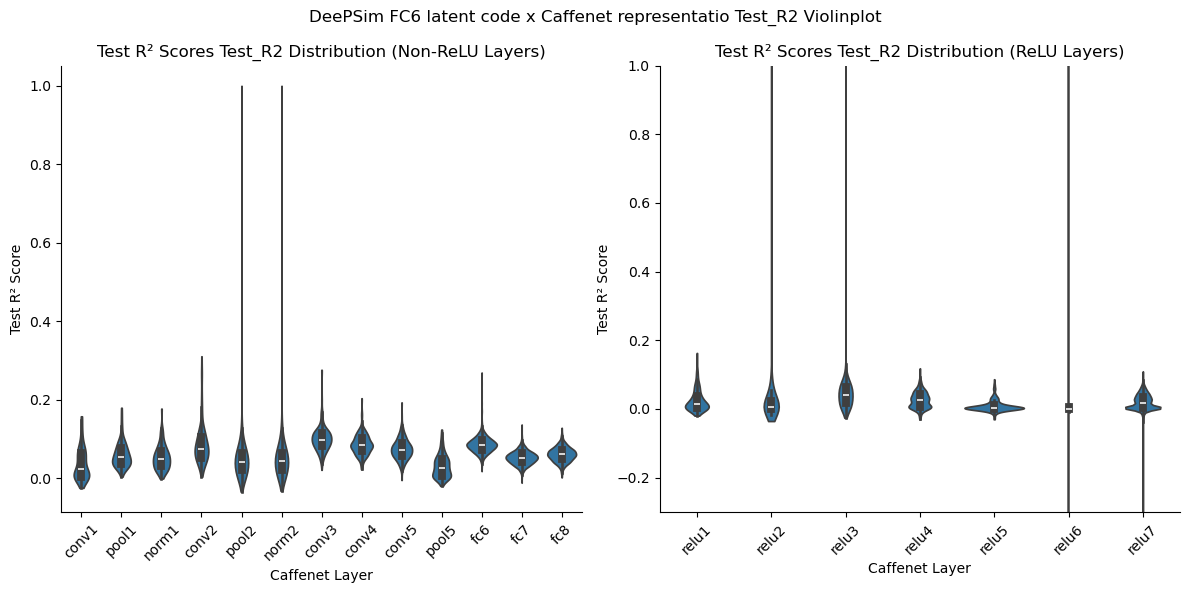

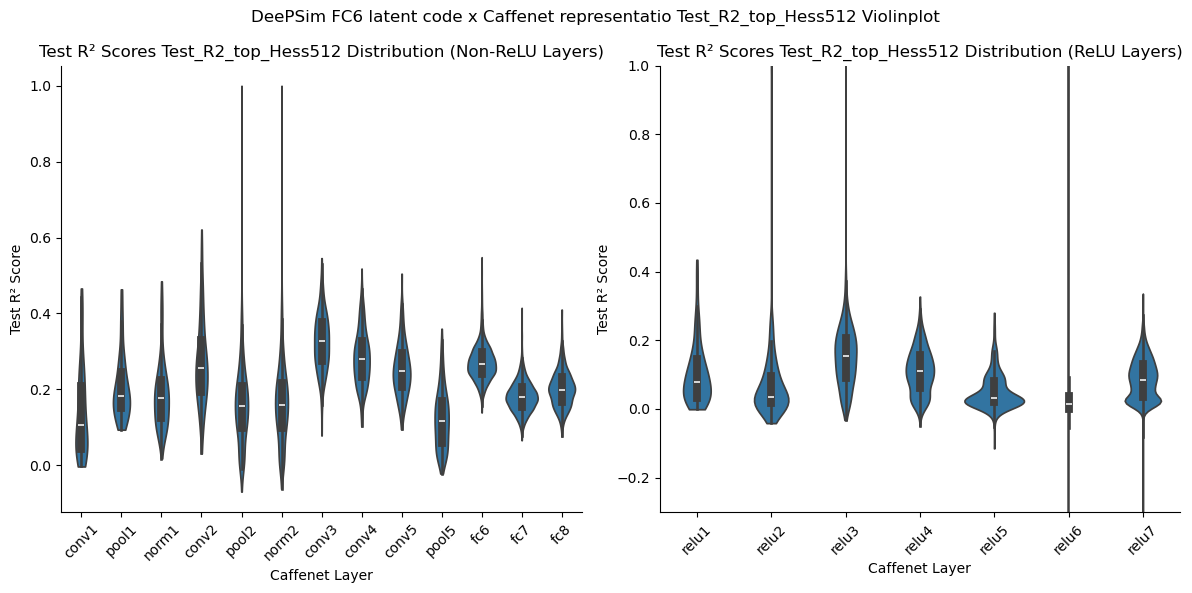

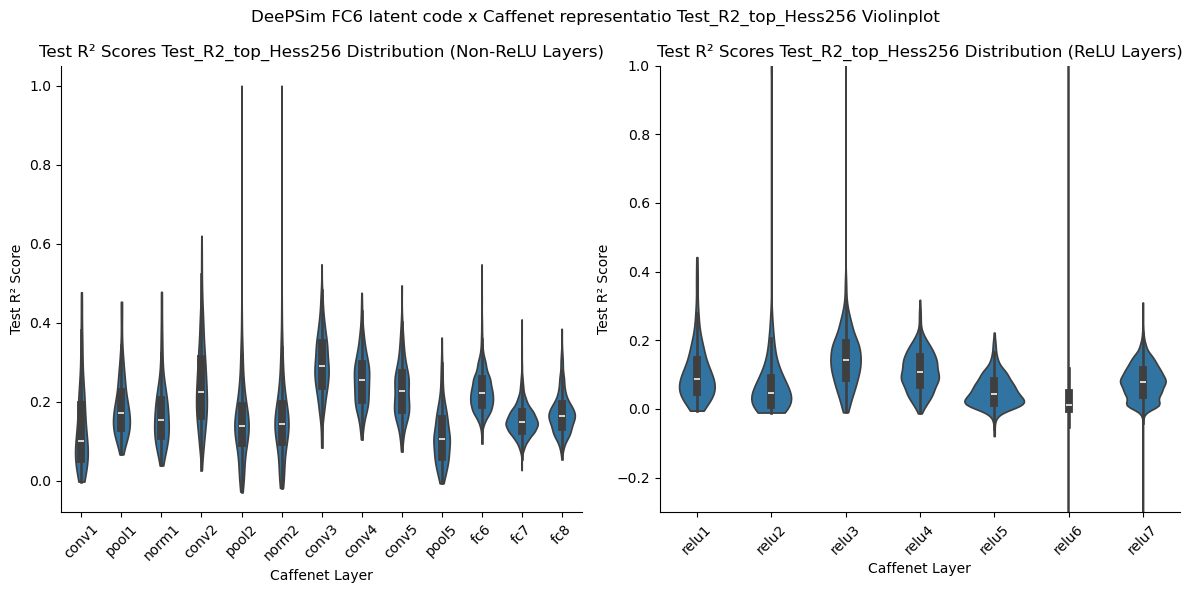

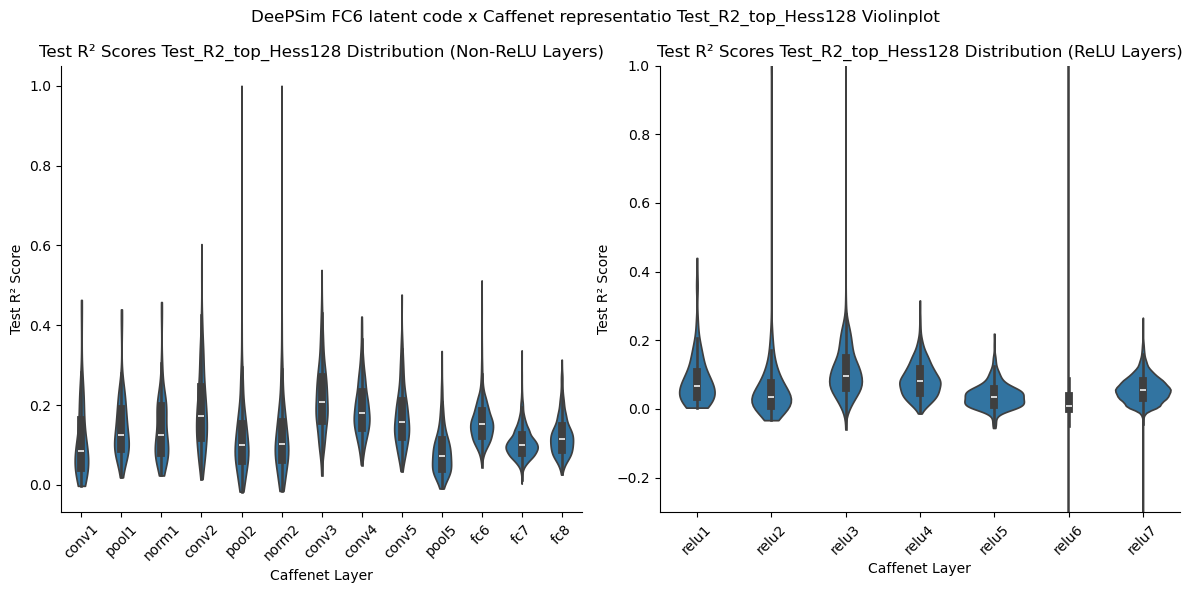

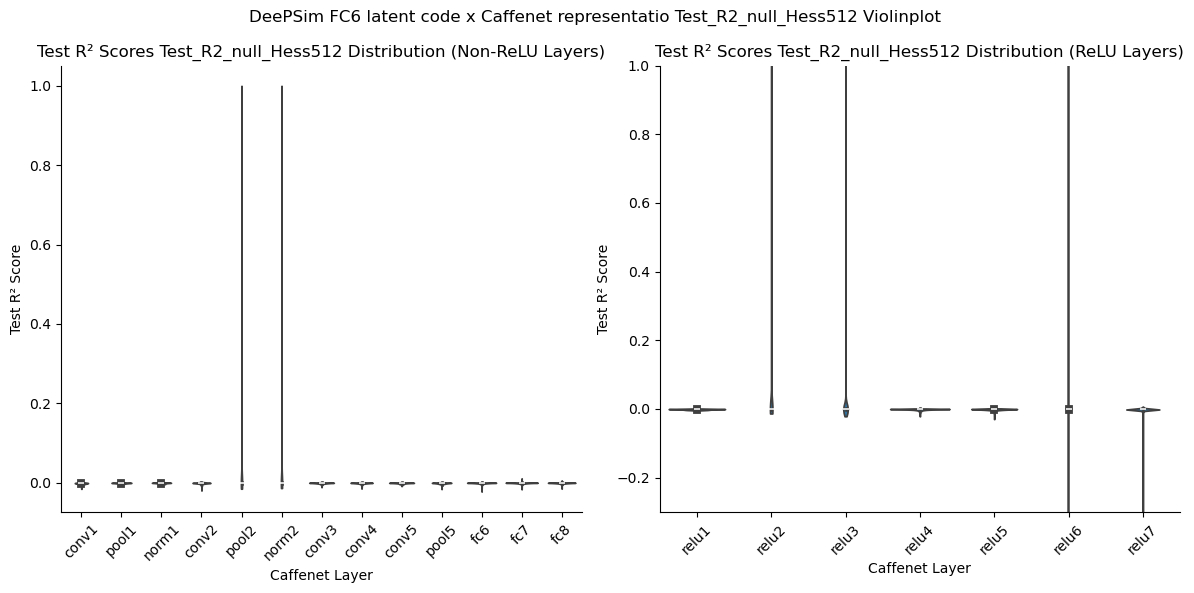

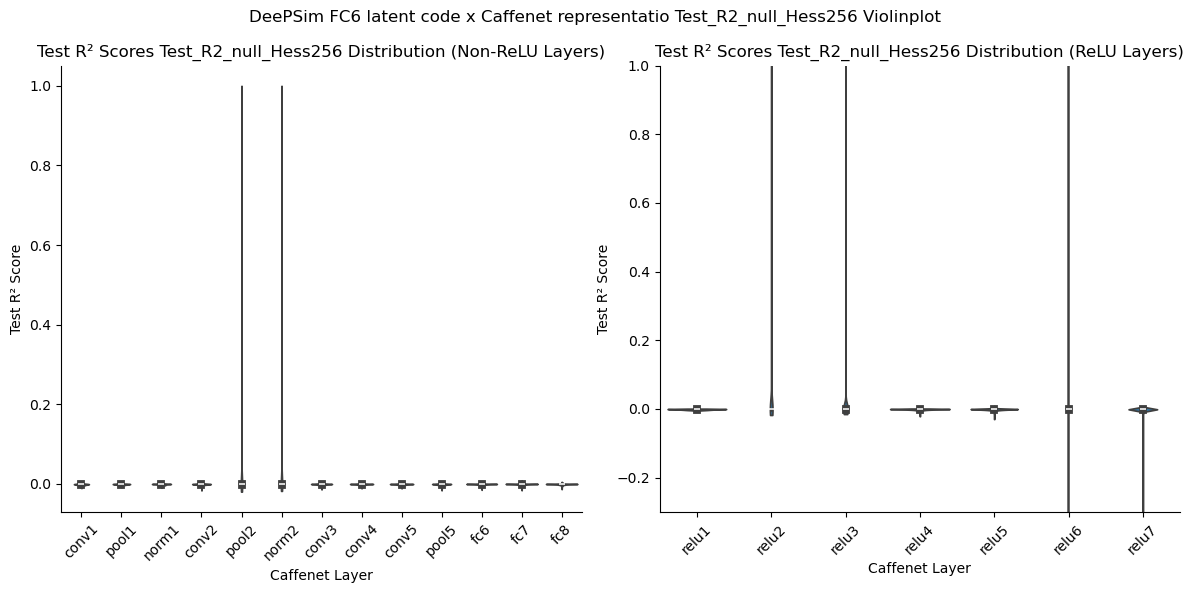

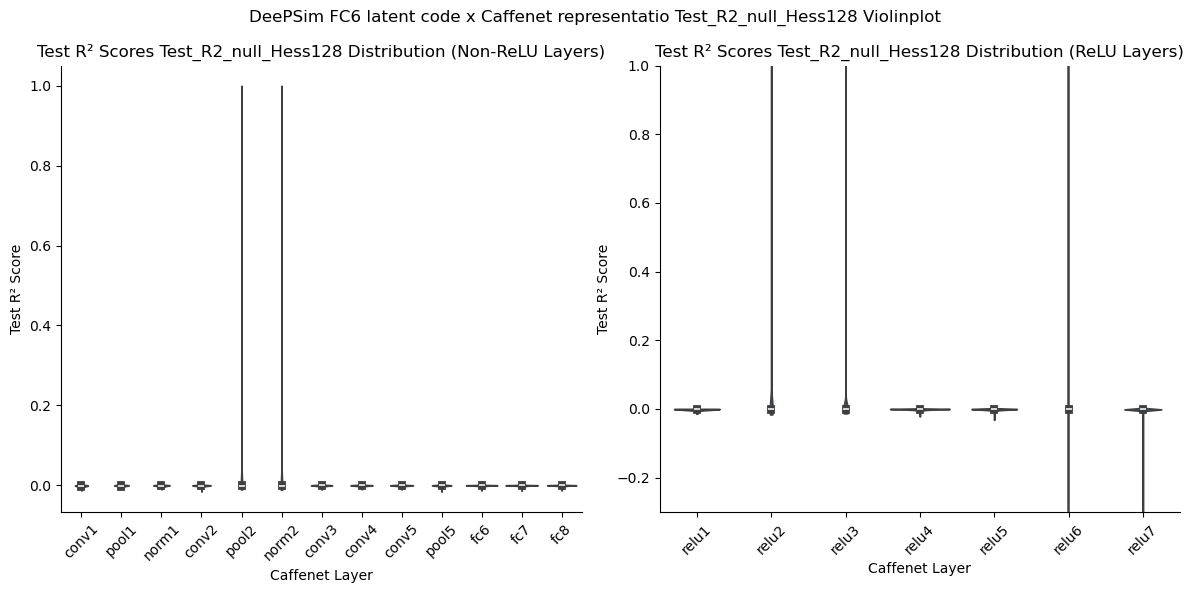

In [106]:
# Plot the results
for y_variable in ["Test_R2", "Test_R2_top_Hess512", "Test_R2_top_Hess256", "Test_R2_top_Hess128", "Test_R2_null_Hess512", "Test_R2_null_Hess256", "Test_R2_null_Hess128"]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.violinplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, cut=0)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.violinplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, cut=0)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    # clip y axis
    ax2.set_ylim(-0.3, 1)
    plt.suptitle(f"DeePSim FC6 latent code x Caffenet representatio {y_variable} Violinplot")
    plt.tight_layout()
    saveallforms(savedir, f"DeePSim_FC6_Caffenet_{y_variable}_violinplot")
    plt.show()

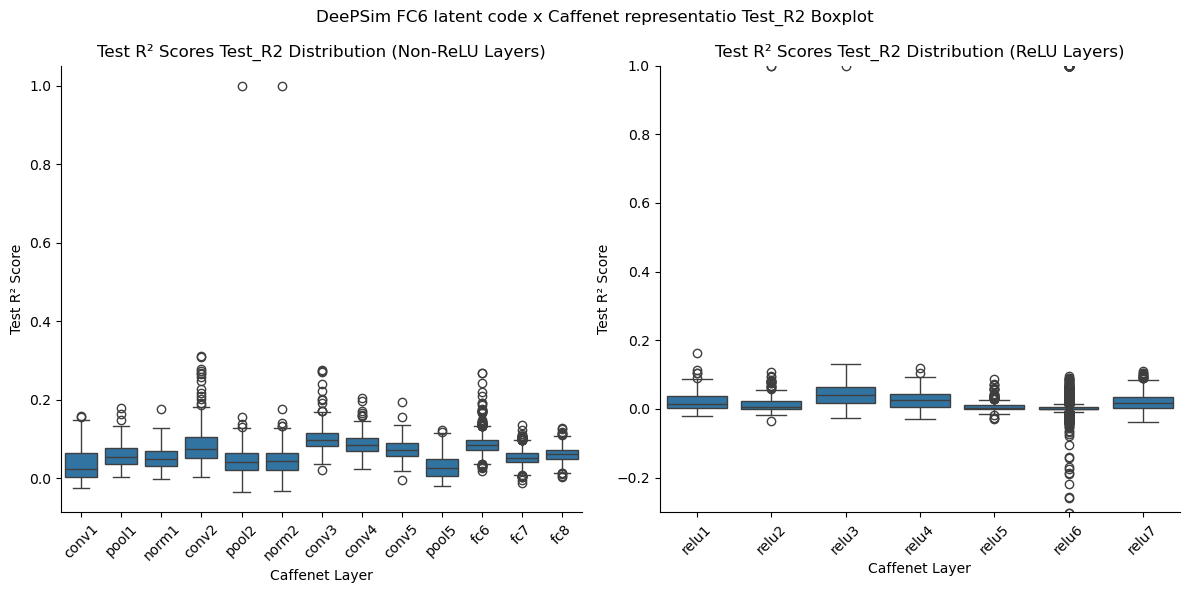

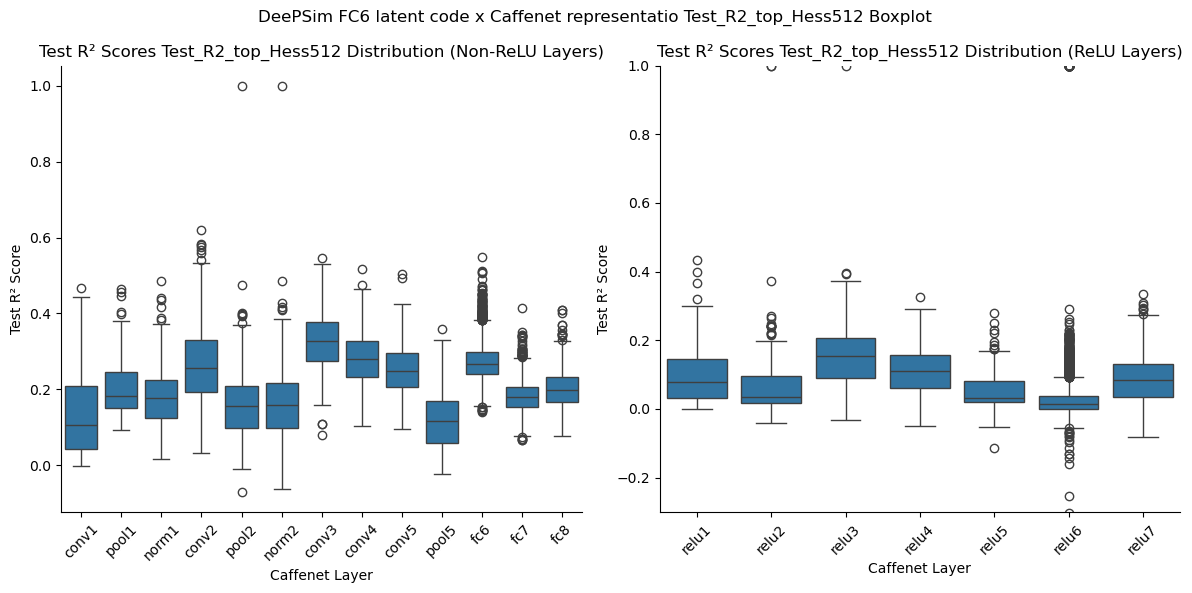

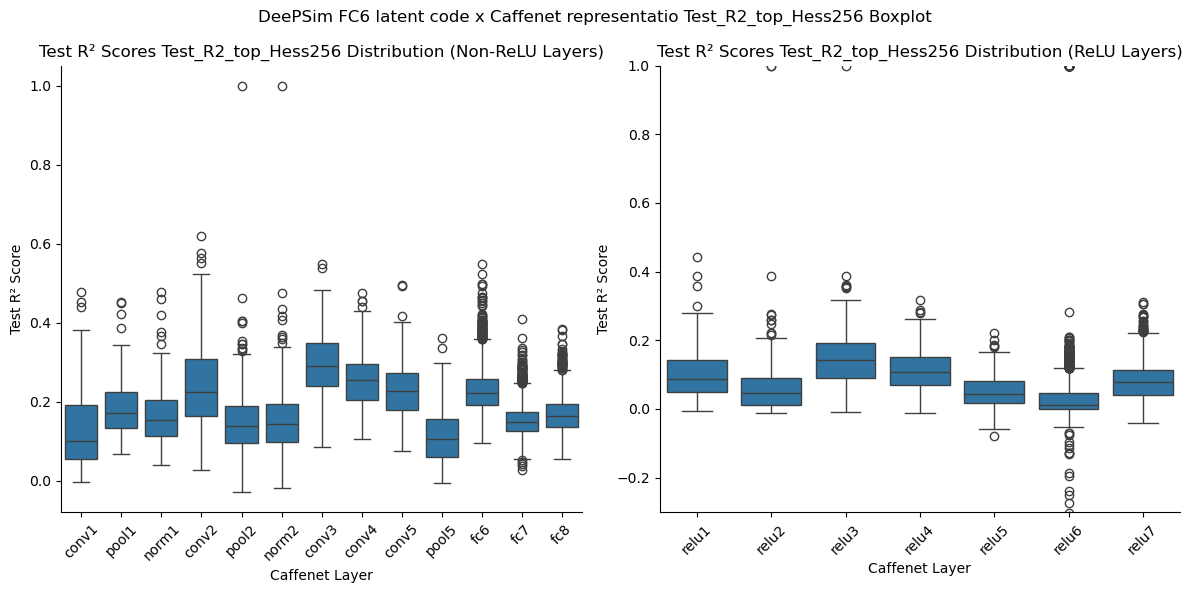

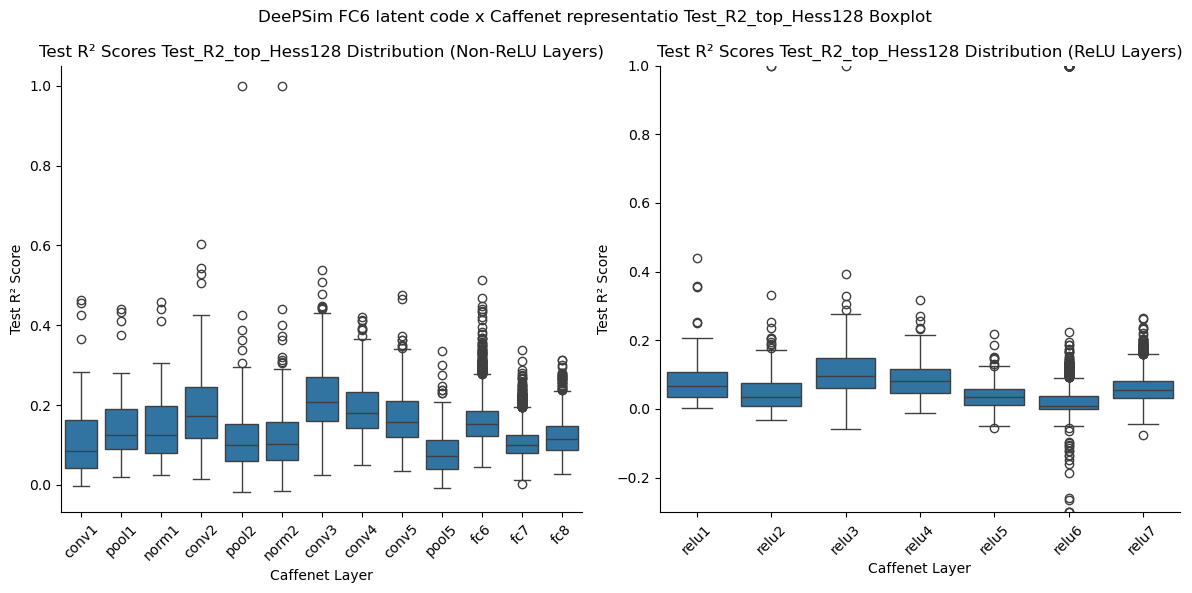

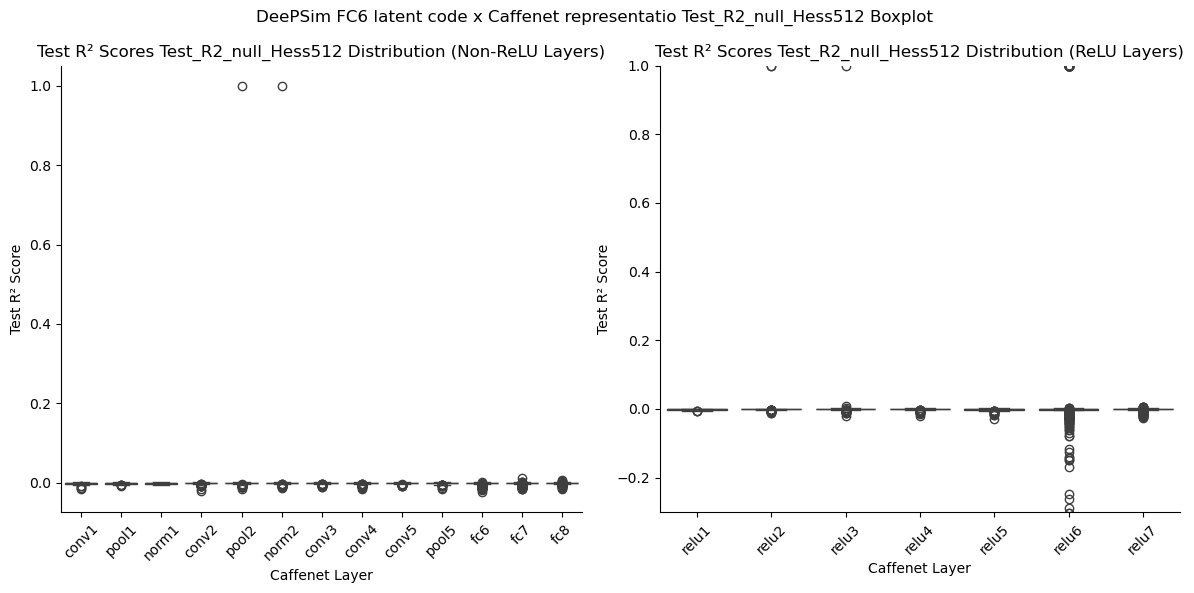

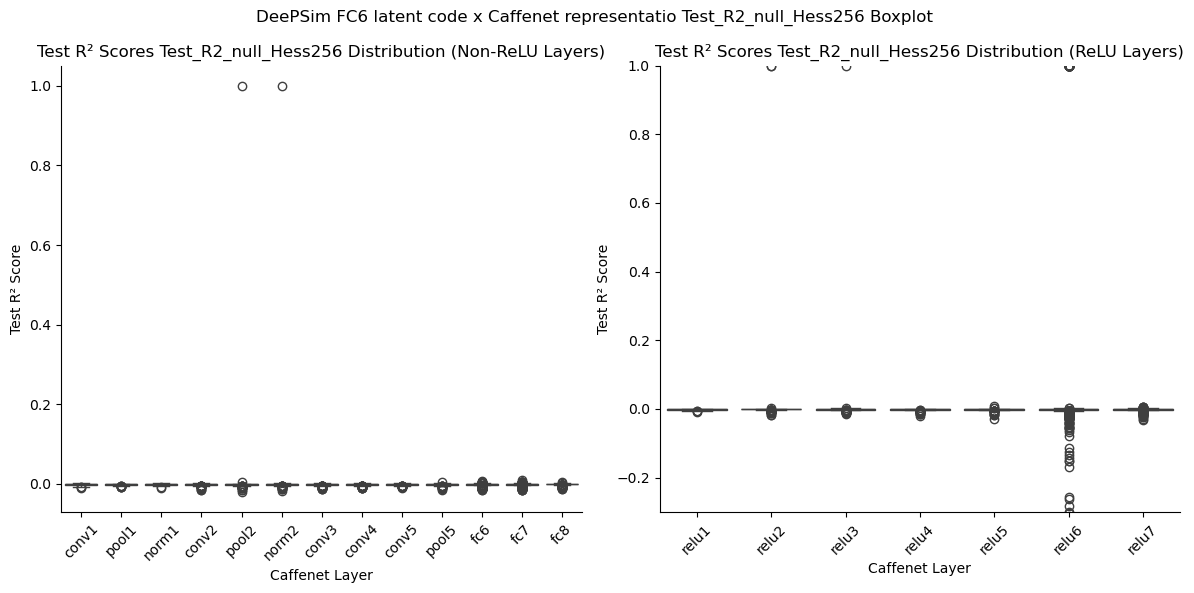

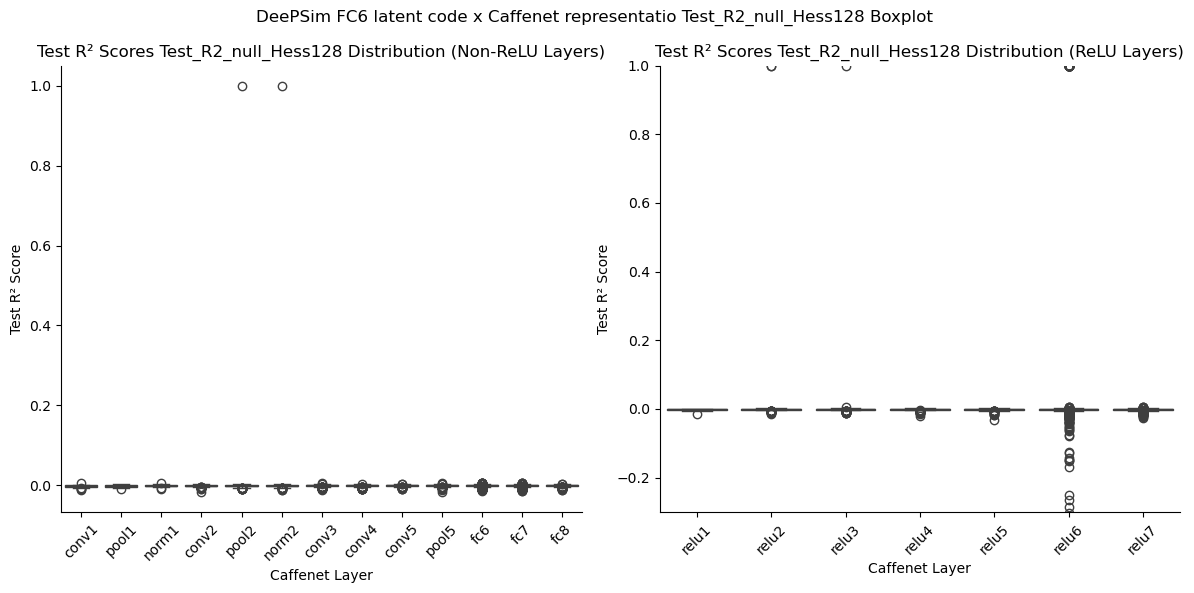

In [107]:
# Plot the results
for y_variable in ["Test_R2", "Test_R2_top_Hess512", "Test_R2_top_Hess256", "Test_R2_top_Hess128", "Test_R2_null_Hess512", "Test_R2_null_Hess256", "Test_R2_null_Hess128"]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.boxplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.boxplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    # clip y axis
    ax2.set_ylim(-0.3, 1)
    plt.suptitle(f"DeePSim FC6 latent code x Caffenet representatio {y_variable} Boxplot")
    plt.tight_layout()
    saveallforms(savedir, f"DeePSim_FC6_Caffenet_{y_variable}_boxplot")
    plt.show()